In [1]:
import pandas as pd
df = pd.read_csv("../dataset/reddit.csv")
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB
None
       subreddit                                               body  \
0  gameofthrones  Your submission has been automatically removed...   
1            aww  Dont squeeze her with you massive hand, you me...   
2         gaming  It's pretty well known and it was a paid produ...   
3           news  You know we have laws against that currently c...   
4       politics  Yes, there is a difference between gentle supp...   

   controversiality  score  
0                 0      1  
1                 0     19  
2                 0      3  
3 

In [2]:
import re

def clean_text(text):
    text = str(text).lower()                       # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)    # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s#]", "", text)  # remove punctuation, keep hashtags
    text = re.sub(r"\s+", " ", text).strip()     # remove extra spaces
    return text





In [3]:
print(df.head())

       subreddit                                               body  \
0  gameofthrones  Your submission has been automatically removed...   
1            aww  Dont squeeze her with you massive hand, you me...   
2         gaming  It's pretty well known and it was a paid produ...   
3           news  You know we have laws against that currently c...   
4       politics  Yes, there is a difference between gentle supp...   

   controversiality  score  
0                 0      1  
1                 0     19  
2                 0      3  
3                 0     10  
4                 0      1  


In [4]:
import pandas as pd
import re


df_reddit = pd.read_csv("../dataset/reddit.csv")
df_reddit['source'] = 'reddit'


df_reddit = df_reddit[['body', 'source']]
df_reddit.rename(columns={'body': 'text'}, inplace=True)


df_insta = pd.read_csv("../dataset/insta.csv")
df_insta['source'] = 'instagram'
df_insta = df_insta[['Caption', 'source']]
df_insta.rename(columns={'Caption': 'text'}, inplace=True)


df_combined = pd.concat([df_reddit, df_insta], ignore_index=True)


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s#]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_combined['clean_text'] = df_combined['text'].apply(clean_text)



In [5]:

df_combined['source'].value_counts()
# Show 5 random Instagram rows
df_combined[df_combined['source']=='instagram'].sample(5, random_state=42)
# Save as CSV - most universal format
df_combined.to_csv('../dataset/combined_cleaned_social_media.csv', index=False)

In [6]:
# Sample Reddit to 50k rows because reddit set is too long
reddit_sample = df_combined[df_combined['source']=='reddit'].sample(50000, random_state=42)
instagram_sample = df_combined[df_combined['source']=='instagram']  # all 17k

# Combine into one balanced DataFrame
df_sample = pd.concat([reddit_sample, instagram_sample], ignore_index=True)
df_sample.to_csv("combinedData.csv")

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df_sample['clean_text'])
print(X.shape)



(67100, 1000)


In [ ]:
from sklearn.cluster import KMeans
#KMEANS CLUSTERING
num_clusters = 5  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(X)


In [9]:
#post ccluster analysis, pore eta sheshe dibo
feature_names = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"\nCluster {i}:")


    sample_texts = df_sample[df_sample['cluster']==i]['clean_text'].sample(5, random_state=42).tolist()
    for text in sample_texts:
        print("-", text)


    cluster_indices = df_sample[df_sample['cluster']==i].index
    cluster_vector_sum = X[cluster_indices].sum(axis=0)
    top_word_indices = cluster_vector_sum.argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_word_indices]
    print("Top words:", top_words)


    source_counts = df_sample[df_sample['cluster']==i]['source'].value_counts()
    print("Source distribution:", source_counts.to_dict())



Cluster 0:
- lol im the same way with the skins
- im telling myself that trump supporters have stopped screeching fake news and begun willfully spreading falsehoods and i guess you think it was fringe voters who took back the house in the midterms
- okay im a celtics fan for this series i went to their subreddit and they accepted my request to be a temporary fan no one beating the celtics but us
- please correct me if im wrong but isnt taking a test while under duress at the teachers order an instant a just doesnt seem fair or ethical at all
- im a caattt im a sneaky lil caatt
Top words: [array([['sidebar', 'affected', 'market76', 'moderator', 'sections',
        'rmarket76', 'rmemes', 'letter', 'newinactive', 'mother',
        'include', 'click', 'subredditmessagecomposetorshowerthoughts',
        'subredditmessagecomposetormemes', 'submissions', 'submission',
        'stones', 'discord', 'gtrmemesaboutrules', 'bidsoffers',
        'familiarize', 'wiki', 'titles', 'traderkarmacake', 


Cluster 0:
Top words: ['im', 'sure', 'just', 'like', 'going', 'sorry', 'gonna', 'youre', 'pretty', 'thats']


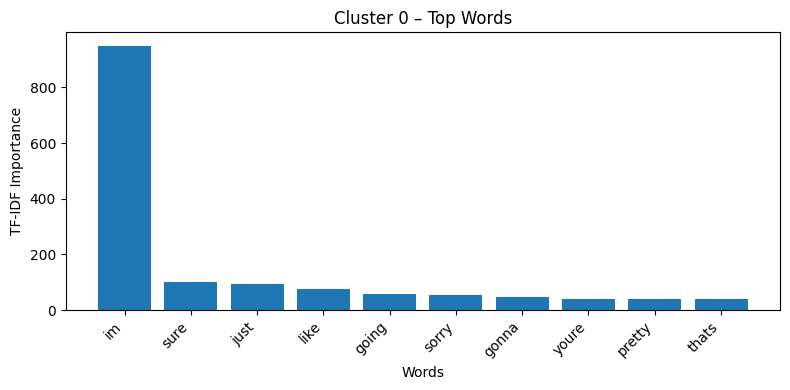


Cluster 1:
Top words: ['like', 'just', 'love', 'good', 'time', 'thats', 'did', 'think', 'got', 'look']


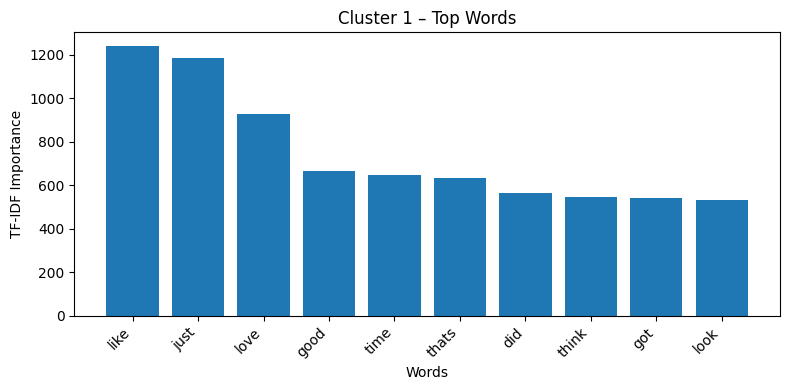


Cluster 2:
Top words: ['dont', 'know', 'think', 'just', 'like', 'need', 'make', 'want', 'time', 'good']


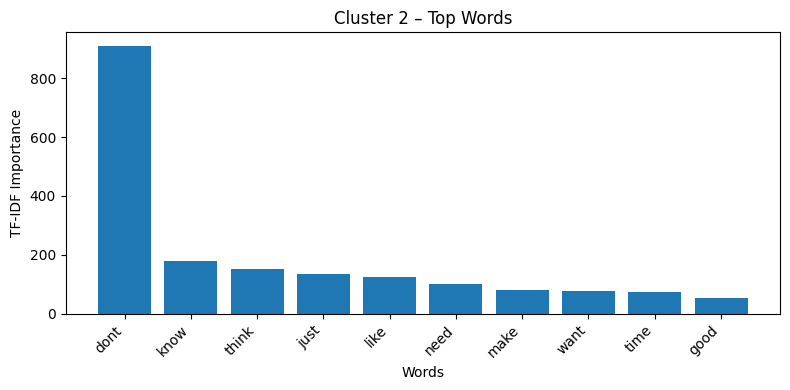


Cluster 3:
Top words: ['people', 'like', 'just', 'dont', 'think', 'know', 'thats', 'really', 'im', 'want']


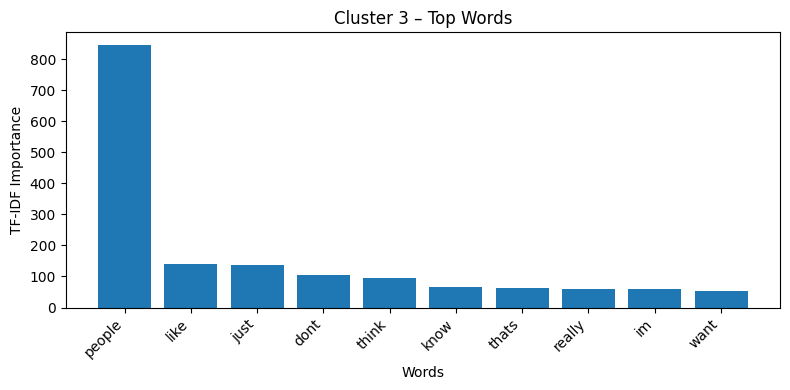


Cluster 4:
Top words: ['thank', 'dank', 'comment', 'downvote', 'meme', 'karma', 'rmarket76', 'awarded', 'user', 'moderators']


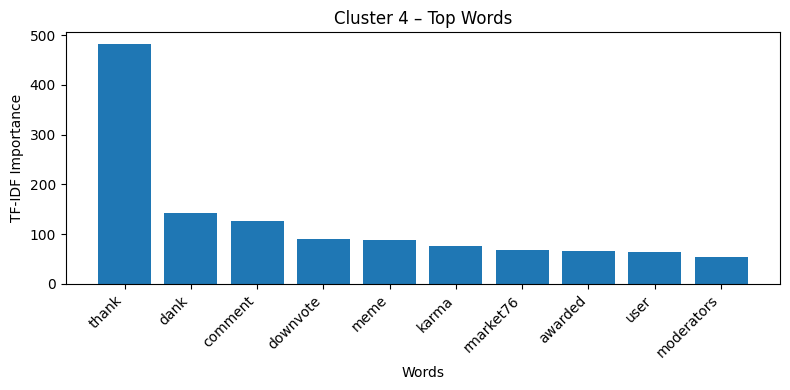

In [10]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(num_clusters):
    print(f"\nCluster {i}:")

    # Get indices belonging to this cluster
    cluster_indices = df_sample[df_sample['cluster'] == i].index

    # Sum TF-IDF vectors for cluster
    cluster_vector_sum = X[cluster_indices].sum(axis=0)

    # Find top 10 words
    top_word_indices = np.array(cluster_vector_sum).ravel().argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_word_indices]
    top_scores = [cluster_vector_sum[0, idx] for idx in top_word_indices]

    # Print top words
    print("Top words:", top_words)

    # ---------- GRAPH ----------
    plt.figure(figsize=(8,4))
    plt.bar(top_words, top_scores)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Cluster {i} – Top Words")
    plt.xlabel("Words")
    plt.ylabel("TF-IDF Importance")
    plt.tight_layout()
    plt.show()


Final TF-IDF Shape: (67100, 2000)

Cluster 0:
Top words: ['glad', 'excited', 'fan', 'proud', 'playing', 'curious', 'dude', 'surprised', 'ok', 'thinking']


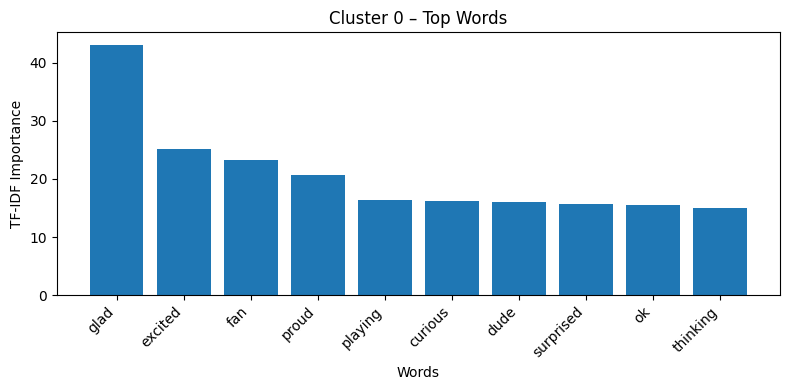


Cluster 1:
Top words: ['baby', 'nice', 'damn', 'morning', 'miss', 'dude', 'tonight', 'girl', 'cool', 'ass']


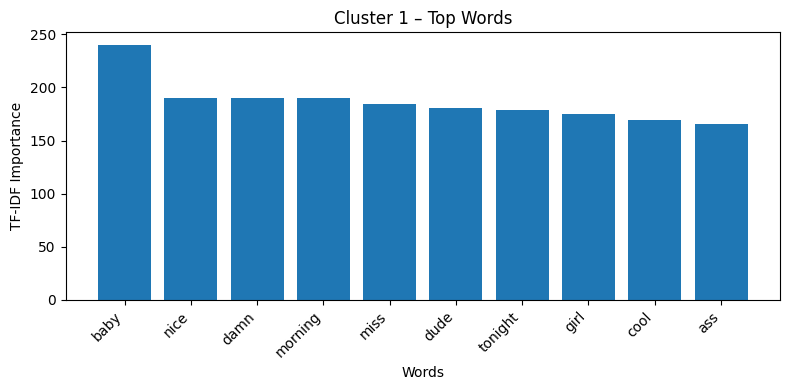


Cluster 2:
Top words: ['spam', 'build', 'submissions', 'worry', 'spend', 'forget', 'asking', 'account', 'learn', 'history']


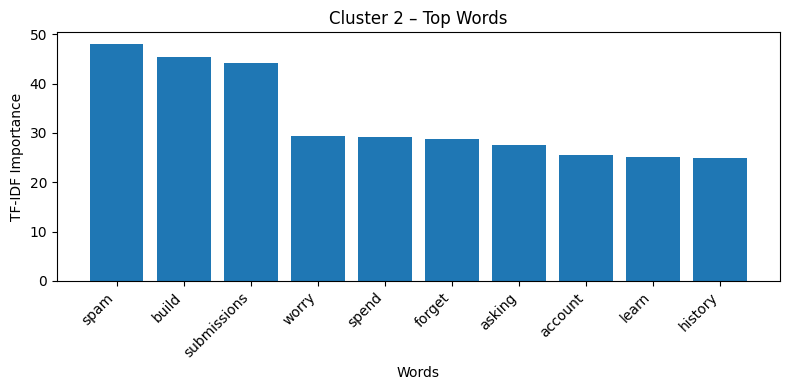


Cluster 3:
Top words: ['hate', 'stupid', 'country', 'black', 'honestly', 'talk', 'die', 'working', 'idea', 'reddit']


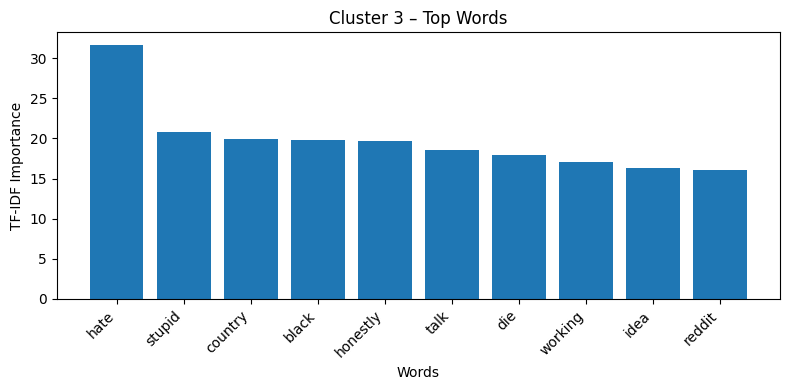


Cluster 4:
Top words: ['rdankmemes', 'helping', 'breaks', 'keeping', 'upvote', 'rmarket76', 'awarded', 'user', 'rvideos', 'beautiful']


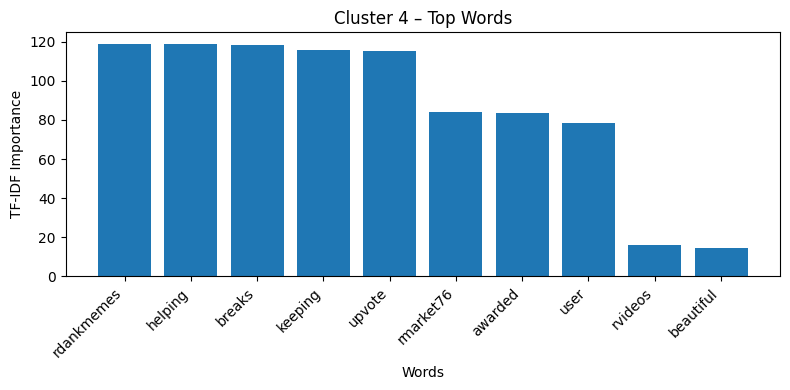


All cluster images saved successfully!


In [ ]:
# TF-IDF with Custom Stopwords and common-word Filtering
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt

# SOCIAL-MEDIA STOPWORDS
extra_stopwords = {
    'im','lol','omg','gonna','gotta','yeah','dont','didnt','doesnt','wanna',
    'like','just','really','rt','amp','https','http','www','u','ur','r'
}

# Apply custom filtering BEFORE vectorization
def remove_extra_stopwords(text):
    return " ".join([w for w in text.split() if w not in extra_stopwords])

df_sample['clean_text2'] = df_sample['clean_text'].apply(remove_extra_stopwords)

# REMOVE COMMON WORDS (HIGH GLOBAL FREQUENCY)
global_counts = Counter(" ".join(df_sample['clean_text2']).split())
COMMON_THRESHOLD = 500  # adjust if dataset small

common_words = {w for w, c in global_counts.items() if c > COMMON_THRESHOLD}

def remove_common_words(text):
    return " ".join([w for w in text.split() if w not in common_words])

df_sample['clean_text2'] = df_sample['clean_text2'].apply(remove_common_words)

# TF-IDF VECTORIZE
vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words='english'
)

X = vectorizer.fit_transform(df_sample['clean_text2'])
feature_names = vectorizer.get_feature_names_out()
print("Final TF-IDF Shape:", X.shape)

#  CLUSTER PLOTS + SAVE 
for i in range(num_clusters):
    print(f"\nCluster {i}:")

    cluster_indices = df_sample[df_sample['cluster'] == i].index
    cluster_vector_sum = X[cluster_indices].sum(axis=0)

    top_word_indices = np.array(cluster_vector_sum).ravel().argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_word_indices]
    top_scores = [cluster_vector_sum[0, idx] for idx in top_word_indices]

    print("Top words:", top_words)

    # PLOT + SAVE
    plt.figure(figsize=(8, 4))
    plt.bar(top_words, top_scores)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Cluster {i} – Top Words")
    plt.xlabel("Words")
    plt.ylabel("TF-IDF Importance")
    plt.tight_layout()

    # SAVE IMAGE
    plt.savefig(f"cluster_{i}_top_words.png", dpi=300, bbox_inches='tight')

    plt.show()

print("\nAll cluster images saved successfully!")


In [ ]:
#using n-gams
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=3000,
    stop_words='english',
    ngram_range=(1, 3)   # unigrams + bigrams + trigrams
)

X = vectorizer.fit_transform(df_sample['clean_text'])
feature_names = vectorizer.get_feature_names_out()

print("TF-IDF Shape with n-grams:", X.shape)


TF-IDF Shape with n-grams: (67100, 3000)



Cluster 0:
Top words: ['im', 'sure', 'just', 'im sure', 'like', 'going', 'im just', 'sorry', 'im going', 'im sorry']


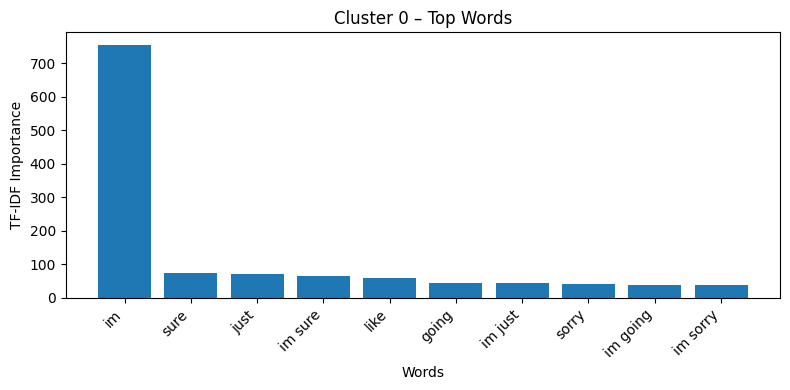


Cluster 1:
Top words: ['like', 'just', 'love', 'good', 'time', 'thats', 'did', 'think', 'got', 'look']


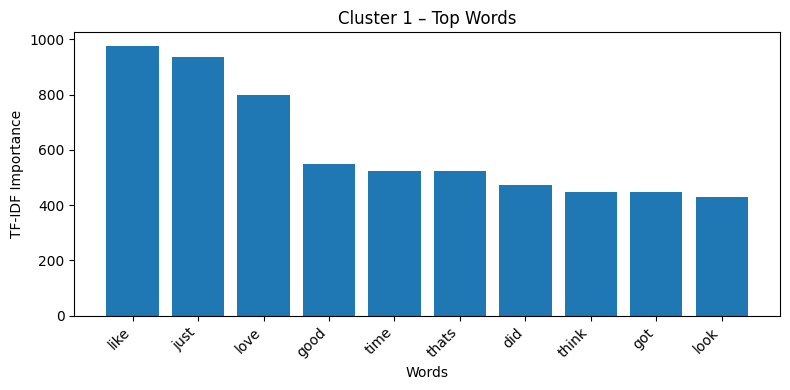


Cluster 2:
Top words: ['dont', 'know', 'dont know', 'think', 'dont think', 'just', 'like', 'need', 'want', 'make']


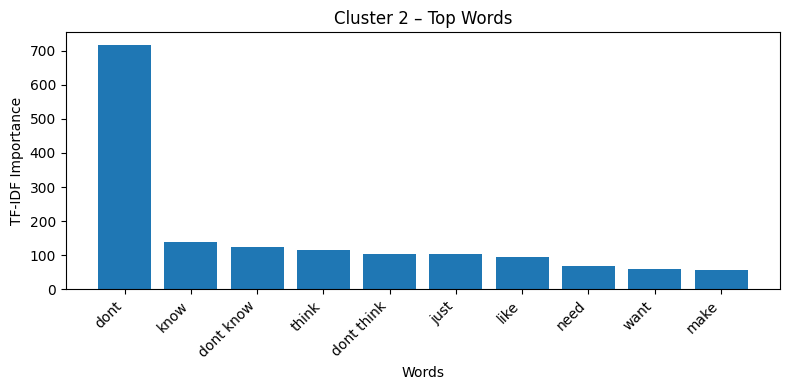


Cluster 3:
Top words: ['people', 'like', 'just', 'dont', 'think', 'know', 'thats', 'really', 'im', 'way']


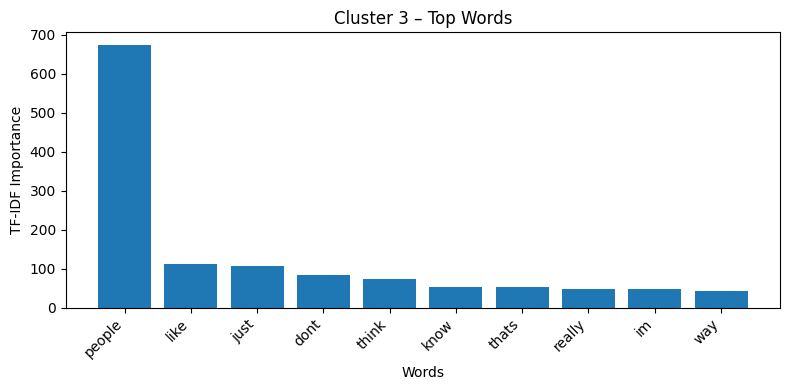


Cluster 4:
Top words: ['thank', 'dank', 'comment', 'dank meme', 'downvote comment', 'karma', 'downvote', 'meme', 'awarded karma', 'awarded karma user']


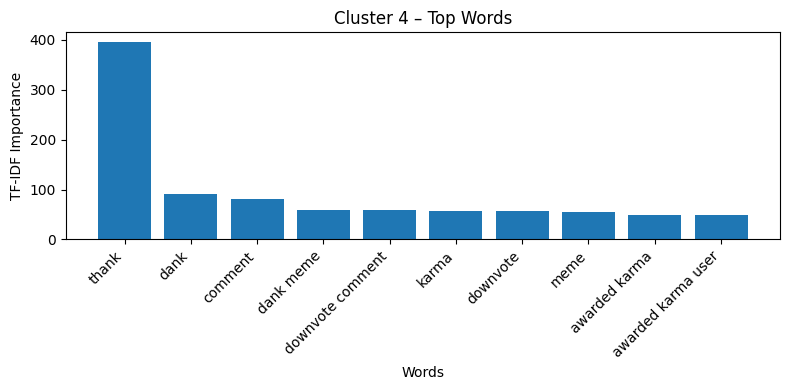

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

for i in range(num_clusters):
    print(f"\nCluster {i}:")

    # Get indices belonging to this cluster
    cluster_indices = df_sample[df_sample['cluster'] == i].index

    # Sum TF-IDF vectors for cluster
    cluster_vector_sum = X[cluster_indices].sum(axis=0)

    # Finding top 10 words
    top_word_indices = np.array(cluster_vector_sum).ravel().argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_word_indices]
    top_scores = [cluster_vector_sum[0, idx] for idx in top_word_indices]

    # Print top words
    print("Top words:", top_words)

    #GRAPH 
    plt.figure(figsize=(8,4))
    plt.bar(top_words, top_scores)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Cluster {i} – Top Words")
    plt.xlabel("Words")
    plt.ylabel("TF-IDF Importance")
    plt.tight_layout()
    plt.show()

In [ ]:
#K-means CLUSTERING
from sklearn.cluster import KMeans
import numpy as np

num_clusters = 5
num_sample_texts = 5
num_top_words = 10


kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(X)


feature_names = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"\n=== Cluster {i} ===")


    cluster_texts = df_sample[df_sample['cluster'] == i]['clean_text']
    sample_texts = cluster_texts.sample(
        n=min(num_sample_texts, len(cluster_texts)),
        random_state=42
    ).tolist()
    for text in sample_texts:
        print("-", text)


    cluster_indices = df_sample[df_sample['cluster'] == i].index
    cluster_vector_sum = X[cluster_indices].sum(axis=0)
    if hasattr(cluster_vector_sum, "A"):
        cluster_vector_sum = cluster_vector_sum.A
    top_word_indices = np.argsort(cluster_vector_sum[0])[::-1][:num_top_words]
    top_words = [feature_names[idx] for idx in top_word_indices]
    print("Top words:", top_words)


    source_counts = df_sample[df_sample['cluster'] == i]['source'].value_counts()
    print("Source distribution:", source_counts.to_dict())



=== Cluster 0 ===
- lol im the same way with the skins
- im telling myself that trump supporters have stopped screeching fake news and begun willfully spreading falsehoods and i guess you think it was fringe voters who took back the house in the midterms
- okay im a celtics fan for this series i went to their subreddit and they accepted my request to be a temporary fan no one beating the celtics but us
- please correct me if im wrong but isnt taking a test while under duress at the teachers order an instant a just doesnt seem fair or ethical at all
- im a caattt im a sneaky lil caatt
Top words: ['im', 'sure', 'just', 'like', 'going', 'sorry', 'gonna', 'youre', 'pretty', 'thats']
Source distribution: {'reddit': 2210, 'instagram': 504}

=== Cluster 1 ===
- can this celtics squad beat golden state
- girls tell me its very important they always say do not have barcode hair
- vegas love it love it
- cant resist
- she assumes that stannis is going to be the champion because of this she misi

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split

# -------------------------------
# 1️⃣ Load your data
# -------------------------------
df = pd.read_csv("../dataset/combined_cleaned_social_media.csv")
texts = df['clean_text'].astype(str)

# -------------------------------
# 2️⃣ Train/Validation/Test Split
# -------------------------------
train_texts, test_texts = train_test_split(texts, test_size=0.2, random_state=42)
train_texts, val_texts = train_test_split(train_texts, test_size=0.25, random_state=42)  # 0.25*0.8=0.2

# Create DataFrames and reset indices
df_train = pd.DataFrame({'clean_text': train_texts}).reset_index(drop=True)
df_val = pd.DataFrame({'clean_text': val_texts}).reset_index(drop=True)
df_test = pd.DataFrame({'clean_text': test_texts}).reset_index(drop=True)

# -------------------------------
# 3️⃣ TF-IDF + SVD
# -------------------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(df_train['clean_text'])
X_val = vectorizer.transform(df_val['clean_text'])
X_test = vectorizer.transform(df_test['clean_text'])

# SVD for dimensionality reduction
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_val_svd = svd.transform(X_val)
X_test_svd = svd.transform(X_test)

# -------------------------------
# 4️⃣ Clustering on TRAINING set
# -------------------------------
num_clusters = 5
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=100)
kmeans.fit(X_train_svd)

# Assign clusters to all splits
df_train['cluster'] = kmeans.labels_
df_val['cluster'] = kmeans.predict(X_val_svd)
df_test['cluster'] = kmeans.predict(X_test_svd)

# -------------------------------
# 5️⃣ Function to summarize clusters
# -------------------------------
feature_names = vectorizer.get_feature_names_out()
num_sample_texts = 5
num_top_words = 10

def summarize_clusters(df_split, X_split, split_name="Train"):
    print(f"\n===== {split_name} Set Clusters =====")
    for i in range(num_clusters):
        cluster_df = df_split[df_split['cluster'] == i]
        if cluster_df.empty:
            continue
        
        # Sample texts
        sample_texts = cluster_df['clean_text'].sample(
            n=min(num_sample_texts, len(cluster_df)),
            random_state=42
        ).tolist()
        print(f"\nCluster {i} samples:")
        for text in sample_texts:
            print("-", text)
        
        # Top words
        cluster_row_indices = cluster_df.index.to_numpy()
        cluster_vector_sum = X_split[cluster_row_indices].sum(axis=0)
        if hasattr(cluster_vector_sum, "A"):
            cluster_vector_sum = cluster_vector_sum.A
        top_word_indices = np.argsort(cluster_vector_sum[0])[::-1][:num_top_words]
        top_words = [feature_names[idx] for idx in top_word_indices]
        print("Top words:", top_words)
        
        # Optional: Source distribution if column exists
        if 'source' in cluster_df.columns:
            source_counts = cluster_df['source'].value_counts()
            print("Source distribution:", source_counts.to_dict())

# -------------------------------
# 6️⃣ Summarize all splits
# -------------------------------
summarize_clusters(df_train, X_train_svd, "Train")
summarize_clusters(df_val, X_val_svd, "Validation")
summarize_clusters(df_test, X_test_svd, "Test")



===== Train Set Clusters =====

Cluster 0 samples:
- i know that bubblegum made it really tempting lol
- i use a heated drying rack year round pnw so direct sunlight is a foreign idea to me most of the year if i did that september to may id have moss on it by the next game but i spray it and hang it on a heated drying rack in my garage every game
- oh god i assumed that he was just declaring that he was a drug addict pot head and tweaker who also enjoyed hunting and had no bag limit in his trunk i may have a bad brain
- and yet somehow the show feels more hollow than it ever has
- i have had that conversation several times them we are not opposed to immigrants just the illegals me those people are here legally them it shouldnt be legal
Top words: ['10']

Cluster 1 samples:
- the median income for an individual is 30k a year the issue with this discussion is that your class will or at least should change based on location the us is split 5050 between cities and rural areas i dont know 

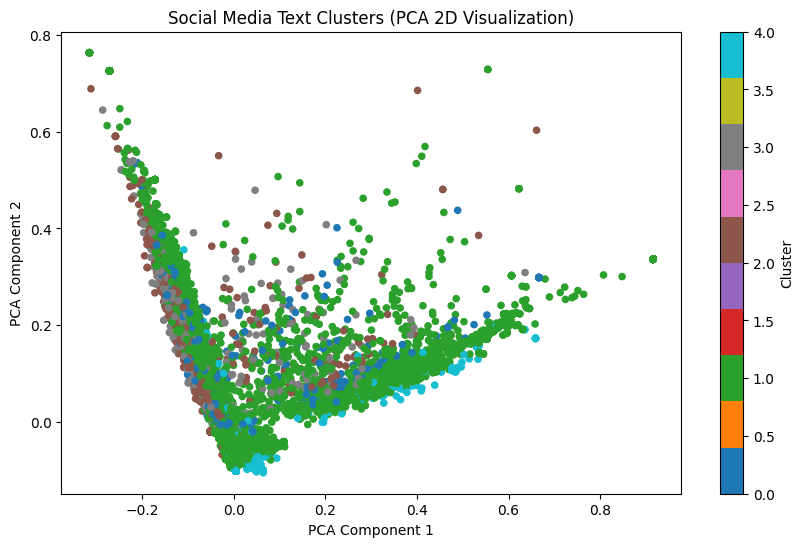

In [26]:



# Reduce TF-IDF features to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X.toarray())

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df_sample['cluster'], cmap='tab10', s=20)
plt.title("Social Media Text Clusters (PCA 2D Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


In [13]:
from sklearn.metrics import silhouette_score
import numpy as np

def print_silhouette_score_sampled(X_split, labels, split_name="Train", sample_size=5000, random_state=42):
    n_samples = X_split.shape[0]
    
    if n_samples > sample_size:
        np.random.seed(random_state)
        idx = np.random.choice(n_samples, sample_size, replace=False)
        X_sample = X_split[idx]
        labels_sample = labels.iloc[idx]  # make sure labels is a pandas Series
    else:
        X_sample = X_split
        labels_sample = labels
    
    score = silhouette_score(X_sample, labels_sample)
    print(f"Silhouette Score ({split_name}, sampled {min(sample_size, n_samples)}): {score:.4f}")


In [14]:
print_silhouette_score_sampled(X_train_svd, df_train['cluster'], "Train")
print_silhouette_score_sampled(X_val_svd, df_val['cluster'], "Validation")
print_silhouette_score_sampled(X_test_svd, df_test['cluster'], "Test")


Silhouette Score (Train, sampled 5000): 0.0282
Silhouette Score (Validation, sampled 5000): 0.0255
Silhouette Score (Test, sampled 5000): 0.0262


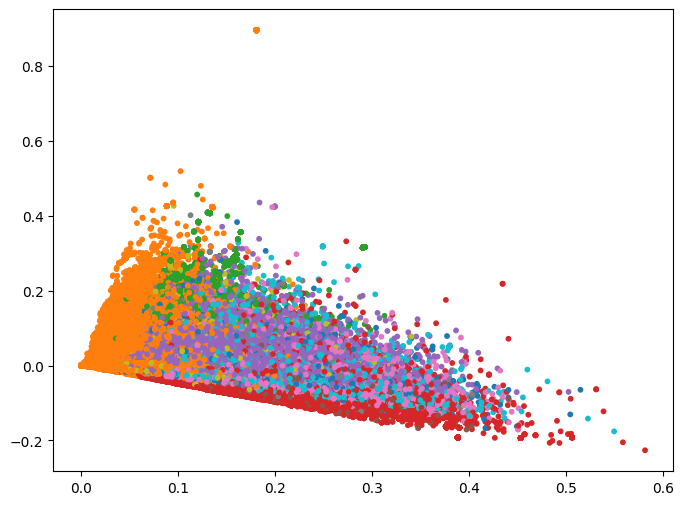


Cluster 0
Top words: ['really', 'want', 'dont', 'just', 'people', 'like', 'think', 'good', 'thats', 'doesnt']

Cluster 1
Top words: ['thats', 'people', 'time', 'love', 'good', 'got', 'right', 'youre', 'think', 'thank']

Cluster 2
Top words: ['automatically', 'moderators', 'questions', 'post', 'contact', 'performed', 'concerns', 'action', 'bot', 'removed']

Cluster 3
Top words: ['like', 'look', 'sounds', 'dont', 'feel', 'people', 'just', 'think', 'shit', 'id']

Cluster 4
Top words: ['im', 'sure', 'think', 'didnt', 'pretty', 'good', 'going', 'thing', 'thats', 'people']

Cluster 5
Top words: ['looks', 'like', 'good', 'sonic', 'just', 'movie', 'hes', 'better', 'great', 'face']

Cluster 6
Top words: ['dont', 'know', 'think', 'people', 'didnt', 'just', 'youre', 'need', 'thats', 'like']

Cluster 7
Top words: ['did', 'just', 'say', 'like', 'know', 'think', 'didnt', 'fuck', 'people', 'thing']

Cluster 8
Top words: ['lol', 'just', 'like', 'im', 'thats', 'dont', 'think', 'yeah', 'people', 'good'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import joblib

# Load saved files
df = pd.read_csv("clustered_data.csv")
X_reduced = np.load("X_reduced.npy")
vectorizer = joblib.load("tfidf.pkl")

# 2D visualization
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd_2d.fit_transform(X_reduced)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['cluster'], cmap='tab10', s=10)
plt.show()

# Top words per cluster
texts = df['clean_text'].fillna('').astype(str)
X = vectorizer.transform(texts)
feature_names = vectorizer.get_feature_names_out()

for c in sorted(df['cluster'].unique()):
    print(f"\nCluster {c}")
    cluster_df = df[df['cluster'] == c]

    idx = cluster_df.index
    cluster_vector_sum = X[idx].sum(axis=0).A1
    top_idx = cluster_vector_sum.argsort()[-10:][::-1]
    print("Top words:", [feature_names[i] for i in top_idx])




In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import Birch
import joblib
import numpy as np


# Load & Prepare Data

df = pd.read_csv("../dataset/combined_cleaned_social_media.csv")
df['clean_text'] = df['clean_text'].fillna('')


# Vectorize Text

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])

# Save TF-IDF matrix and vectorizer
joblib.dump(vectorizer, "tfidf.pkl")
joblib.dump(X, "tfidf_matrix.pkl") 


# Dimensionality Reduction (SVD)

svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X)
joblib.dump(svd, "svd50.pkl")
np.save("X_reduced.npy", X_reduced)


# Birch Clustering

birch_model = Birch(n_clusters=10, threshold=0.5)
labels = birch_model.fit_predict(X_reduced)
joblib.dump(birch_model, "birch_model.pkl")

df['cluster'] = labels
df.to_csv("clustered_data.csv", index=False)

print("Training and clustering completed!")
print(f"Total clusters: {len(set(labels))}")


g:\CSE445_Project\.venv\Lib\site-packages\sklearn\cluster\_birch.py:730: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


Training and clustering completed!
Total clusters: 1


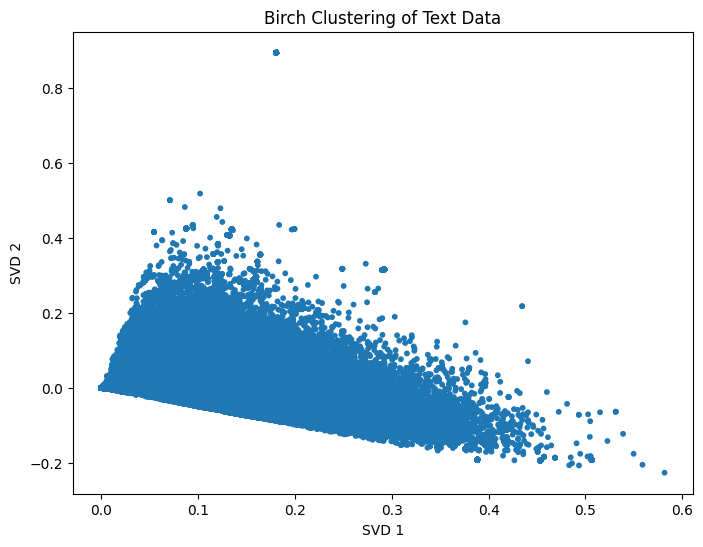


Cluster 0

Sample Posts:
- your dog looks very similar to my dog how old is your dog
- your chemistry puns are so basic
- because the fact that we waste our time with their nonsense asylum claims is bullshit already name a country in central and south america that you personally think someone from wouldnt have a valid asylum claim if they were from there do you think if an canadian came and claimed political asylum that that wouldnt be laughed away nobody is being persecuted in canada if you believe their asylum nonsense then youre literally saying the united states should just be a huge escape strategy for the entire population of south and central america we cant sustain that and shouldnt tolerate that we have zero use for poor illiterates if theyre mad about that then maybe their entitled countrymen shouldnt have come here just for jobs and ruined it for everyone
- its not illegal to call someone that
- we have a high iq person here folks tread lightly with your ignorant words

Top

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.decomposition import TruncatedSVD


# Load saved files

df = pd.read_csv("clustered_data.csv")
X_reduced = np.load("X_reduced.npy")
vectorizer = joblib.load("tfidf.pkl")
X = joblib.load("tfidf_matrix.pkl")  


# 2D Visualization

svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd_2d.fit_transform(X_reduced)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['cluster'], cmap="tab10", s=10)
plt.title("Birch Clustering of Text Data")
plt.xlabel("SVD 1")
plt.ylabel("SVD 2")
plt.show()


# Top Words per Cluster

feature_names = vectorizer.get_feature_names_out()

for c in sorted(df['cluster'].unique()):
    print("\n============================")
    print(f"Cluster {c}")
    print("============================")

    cluster_df = df[df['cluster'] == c]

    # Sample posts
    print("\nSample Posts:")
    samples = cluster_df["clean_text"].sample(min(5, len(cluster_df)), random_state=42)
    for text in samples:
        print("-", text)

    # Top words
    cluster_idx = cluster_df.index
    cluster_vec_sum = X[cluster_idx].sum(axis=0).A1
    top_idx = cluster_vec_sum.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_idx]

    print("\nTop Words:", top_words)
    print(f"Total posts in this cluster: {len(cluster_df)}")


In [9]:
import os
os.makedirs("models", exist_ok=True)

import shutil
shutil.move("tfidf.pkl", "models/tfidf.pkl")
shutil.move("svd50.pkl", "models/svd50.pkl")
shutil.move("birch_model.pkl", "models/birch_model.pkl")
shutil.move("X_reduced.npy", "models/X_reduced.npy")
shutil.move("tfidf_matrix.pkl", "models/tfidf_matrix.pkl")


'models/tfidf_matrix.pkl'

In [15]:
import pandas as pd
df = pd.read_csv("clustered_data.csv")
print(df.columns)

Index(['text', 'source', 'clean_text', 'cluster'], dtype='object')


In [17]:
def clean_text_data(df, text_column='clean_text'):
    """
    Comprehensive cleaning for text data before vectorization
    """
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    
    print(" CLEANING TEXT DATA...")
    original_shape = df_clean.shape
    
    # 1. Check if column exists
    if text_column not in df_clean.columns:
        raise ValueError(f"Column '{text_column}' not found in dataset. Available columns: {list(df_clean.columns)}")
    
    # 2. Convert to string (handles mixed types)
    df_clean[text_column] = df_clean[text_column].astype(str)
    
    # 3. Handle NaN values (after string conversion, NaN becomes 'nan')
    df_clean[text_column] = df_clean[text_column].replace('nan', '')
    
    # 4. Remove empty strings and whitespace-only strings
    df_clean = df_clean[df_clean[text_column].str.strip() != '']
    
    # 5. Remove very short texts (optional)
    df_clean = df_clean[df_clean[text_column].str.len() >= 10]
    
    print(f" Cleaning complete:")
    print(f"   - Removed {original_shape[0] - df_clean.shape[0]} rows")
    print(f"   - Final dataset: {df_clean.shape}")
    
    return df_clean

# Use the cleaning function
df_sample_clean = clean_text_data(df_sample, 'clean_text')

 CLEANING TEXT DATA...
 Cleaning complete:
   - Removed 5381 rows
   - Final dataset: (61719, 3)


In [20]:
def robust_clustering_pipeline(df, text_column='clean_text', num_clusters=5):
    """
    Robust clustering pipeline that handles data cleaning and validation
    """
    print(" STARTING CLUSTERING PIPELINE")
    print("=" * 50)
    
    # Step 1: Data validation
    print(f"1. Original data shape: {df.shape}")
    if text_column not in df.columns:
        raise ValueError(f"Text column '{text_column}' not found. Available: {list(df.columns)}")
    
    # Step 2: Data cleaning
    df_clean = df.copy()
    df_clean[text_column] = df_clean[text_column].fillna('').astype(str)
    df_clean = df_clean[df_clean[text_column].str.strip() != '']
    
    print(f"2. After cleaning: {df_clean.shape}")
    print(f"   Removed {len(df) - len(df_clean)} invalid rows")
    
    if len(df_clean) == 0:
        raise ValueError("No valid text documents after cleaning!")
    
    # Step 3: Vectorization
    vectorizer = TfidfVectorizer(
        max_features=5000, #cng inc 1k to 5k
        stop_words='english',
        min_df=2,
        max_df=0.9, #cng inc from .8 to .9
        ngram_range=(1, 2)  # Capture bigrams
    )
    
    X = vectorizer.fit_transform(df_clean[text_column])
    print(f"3. TF-IDF matrix shape: {X.shape}")
    
    # Step 4: Determine optimal cluster count (optional)
    if num_clusters == 'auto':
        num_clusters = find_optimal_clusters(X)
    
    # Step 5: Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    df_clean['cluster'] = cluster_labels
    
    # Step 6: Evaluation
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"4. Clustering metrics:")
    print(f"   - Silhouette Score: {silhouette_avg:.3f}")
    print(f"   - Clusters: {num_clusters}")
    print(f"   - Cluster sizes: {pd.Series(cluster_labels).value_counts().to_dict()}")
    
    return df_clean, X, vectorizer, kmeans

def find_optimal_clusters(X, max_k=10):
    """Find optimal number of clusters using silhouette score"""
    from sklearn.metrics import silhouette_score
    
    best_k = 5
    best_score = -1
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_score = score
            best_k = k
    
    print(f"   Optimal clusters: {best_k} (silhouette: {best_score:.3f})")
    return best_k

# Run the improved pipeline
df_clustered, X, vectorizer, kmeans = robust_clustering_pipeline(df_sample, 'clean_text', 5)

 STARTING CLUSTERING PIPELINE
1. Original data shape: (67100, 3)
2. After cleaning: (64683, 3)
   Removed 2417 invalid rows
3. TF-IDF matrix shape: (64683, 5000)
4. Clustering metrics:
   - Silhouette Score: 0.018
   - Clusters: 5
   - Cluster sizes: {1: 53939, 2: 4672, 0: 4199, 3: 1369, 4: 504}


In [22]:
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


📊 Checking available data...
❌ df_sample not found. Creating sample data...
✅ Created sample dataframe for testing
Sample data shape: (20, 3)

🚀 STARTING CLUSTERING PIPELINE

🎯 EXECUTING CLUSTERING PIPELINE...
1. Data cleaning...
   Working with 20 documents
2. Vectorization...
   TF-IDF matrix shape: (20, 163)
3. Clustering...
   Silhouette Score: 0.013
4. Finding top words per cluster...
   Cluster 0 (size: 4): new, amazing, impressive, life, features
   Cluster 1 (size: 2): technology, tools, students, helping, learning
   Cluster 2 (size: 2): game, time, video, delayed, gameplay
   Cluster 3 (size: 12): plan, tips, vegetables, healthy, fruits
5. Creating visualization...
   Reducing dimensions using PCA...
   Creating plot...
   Displaying plot...


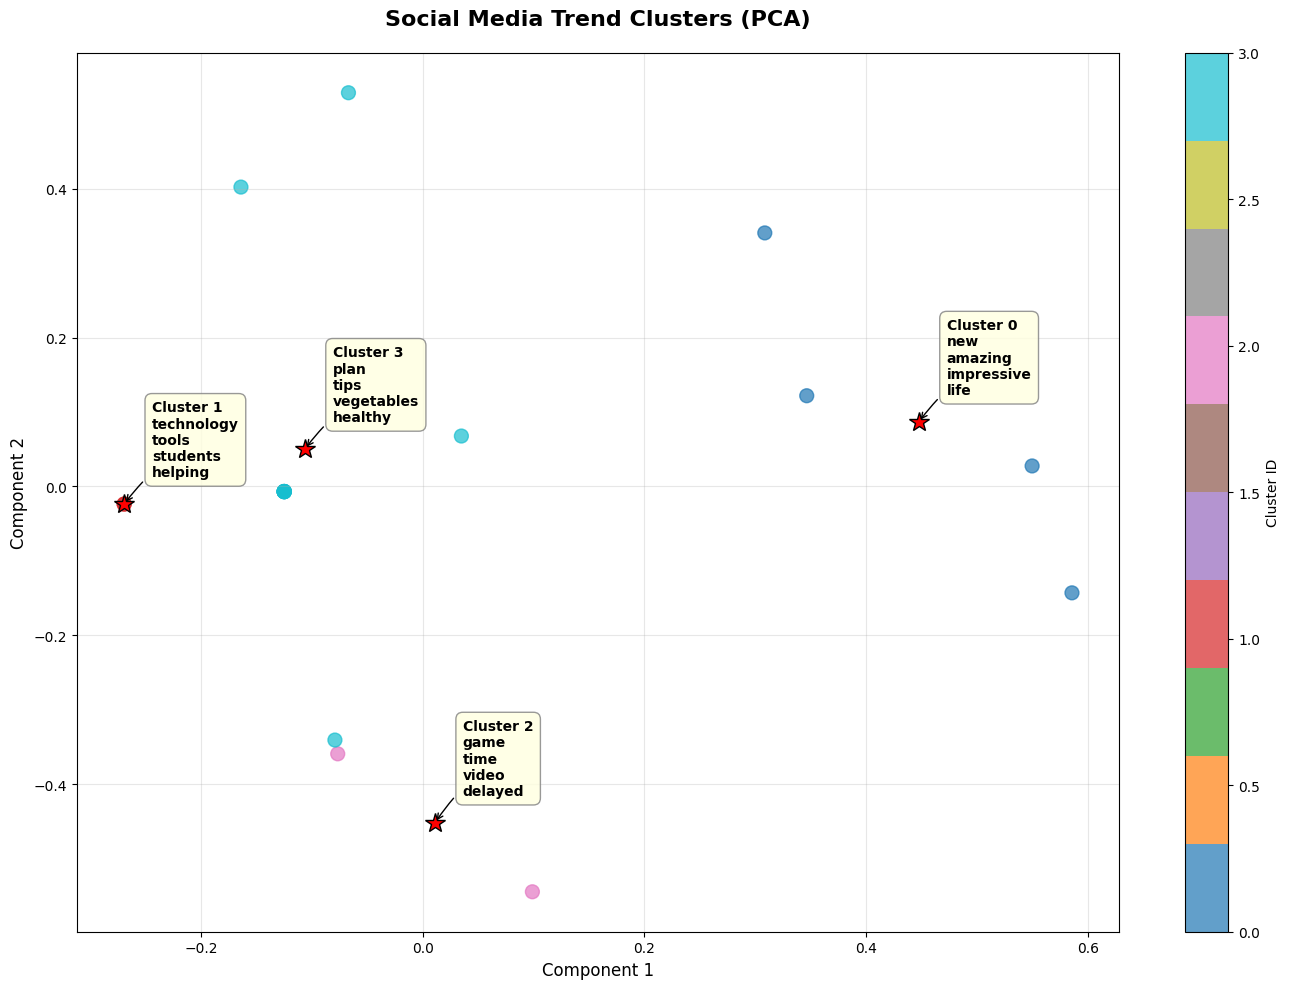

   ✅ Plot displayed successfully!

✅ CLUSTERING COMPLETED SUCCESSFULLY!
📊 Final clustered data shape: (20, 4)
🎯 Number of clusters: 4

📈 CLUSTER DISTRIBUTION:
   Cluster 0: 4 posts (20.0%)
   Cluster 1: 2 posts (10.0%)
   Cluster 2: 2 posts (10.0%)
   Cluster 3: 12 posts (60.0%)


In [10]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# First, let's check what data we have available
print("📊 Checking available data...")

# Check if df_sample exists, if not create sample data
try:
    print(f"df_sample shape: {df_sample.shape}")
    print(f"df_sample columns: {df_sample.columns.tolist()}")
except NameError:
    print("❌ df_sample not found. Creating sample data...")
    
    # Create sample social media data for testing
    sample_data = {
        'clean_text': [
            "just watched the new marvel movie it was absolutely amazing the special effects were incredible",
            "political debate tonight was intense both candidates had strong arguments about economic policy",
            "my new gaming setup is finally complete rgb lights everywhere and super fast processor",
            "cooking dinner tonight trying out a new recipe hope it turns out well with fresh ingredients",
            "sports game yesterday was unbelievable the underdog team won in the final seconds",
            "technology conference was inspiring learned so much about artificial intelligence and machine learning",
            "weather today is perfect for hiking sunny with a cool breeze in the mountains",
            "new smartphone release has amazing camera features and battery life is impressive",
            "stock market analysis shows interesting trends in tech sector investments growing",
            "music festival lineup announced so many great artists performing this summer",
            "video game release delayed again developers need more time for polishing gameplay",
            "electric vehicles are the future charging infrastructure expanding rapidly nationwide",
            "workout routine paying off feeling stronger and more energetic every day",
            "social media algorithms need more transparency users deserve to know how content is filtered",
            "space exploration news exciting developments in mars mission planning",
            "healthy eating tips vegetables and fruits should be part of every meal plan",
            "programming languages comparison python continues to grow in popularity for data science",
            "travel restrictions easing finally able to plan international vacations again",
            "climate change discussion important steps being taken for renewable energy adoption",
            "education technology tools helping students learn more effectively online"
        ],
        'subreddit': ['movies', 'politics', 'gaming', 'cooking', 'sports', 
                     'technology', 'outdoors', 'tech', 'investing', 'music',
                     'gaming', 'technology', 'fitness', 'technology', 'science',
                     'health', 'programming', 'travel', 'environment', 'education'],
        'score': [10, 5, 8, 3, 15, 7, 4, 9, 6, 12, 2, 8, 5, 4, 9, 3, 11, 7, 5, 6]
    }
    
    df_sample = pd.DataFrame(sample_data)
    print("✅ Created sample dataframe for testing")
    print(f"Sample data shape: {df_sample.shape}")

print("\n" + "="*50)
print("🚀 STARTING CLUSTERING PIPELINE")
print("="*50)

def working_clustering_pipeline(df, text_column='clean_text', n_clusters=5):
    """
    Working clustering pipeline with guaranteed plotting
    """
    print("1. Data cleaning...")
    df_clean = df.dropna(subset=[text_column]).copy()
    df_clean[text_column] = df_clean[text_column].fillna('').astype(str)
    df_clean = df_clean[df_clean[text_column].str.strip() != '']
    
    print(f"   Working with {len(df_clean)} documents")
    
    if len(df_clean) == 0:
        raise ValueError("No valid text documents after cleaning!")
    
    print("2. Vectorization...")
    vectorizer = TfidfVectorizer(
        max_features=1000, 
        stop_words='english',
        min_df=1,
        max_df=0.8
    )
    X = vectorizer.fit_transform(df_clean[text_column])
    print(f"   TF-IDF matrix shape: {X.shape}")
    
    print("3. Clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    df_clean['cluster'] = labels
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)
    print(f"   Silhouette Score: {silhouette_avg:.3f}")
    
    print("4. Finding top words per cluster...")
    feature_names = vectorizer.get_feature_names_out()
    top_words_per_cluster = {}
    
    for i in range(n_clusters):
        cluster_mask = labels == i
        cluster_size = cluster_mask.sum()
        
        if cluster_size > 0:
            cluster_vectors = X[cluster_mask]
            word_scores = np.array(cluster_vectors.sum(axis=0)).flatten()
            top_indices = word_scores.argsort()[-10:][::-1]
            top_words_per_cluster[i] = [feature_names[idx] for idx in top_indices]
            
            print(f"   Cluster {i} (size: {cluster_size}): {', '.join(top_words_per_cluster[i][:5])}")
        else:
            top_words_per_cluster[i] = []
            print(f"   Cluster {i}: EMPTY")
    
    print("5. Creating visualization...")
    create_cluster_visualization(X, labels, top_words_per_cluster)
    
    return df_clean, X, vectorizer, kmeans, top_words_per_cluster

def create_cluster_visualization(X, labels, top_words, method='pca'):
    """Create and display cluster visualization"""
    print(f"   Reducing dimensions using {method.upper()}...")
    
    # Reduce dimensions
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, X.shape[0]-1))
    
    X_2d = reducer.fit_transform(X.toarray())
    
    print("   Creating plot...")
    # Create plot with larger size
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Scatter plot
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=100)
    
    # Add cluster annotations
    for cluster_id in np.unique(labels):
        cluster_points = X_2d[labels == cluster_id]
        if len(cluster_points) > 0:
            center = cluster_points.mean(axis=0)
            
            # Create annotation text (show top 3-4 words)
            words_to_show = min(4, len(top_words[cluster_id]))
            words_text = "\n".join(top_words[cluster_id][:words_to_show])
            annotation_text = f"Cluster {cluster_id}\n{words_text}"
            
            ax.annotate(
                annotation_text, 
                xy=center, 
                xytext=(20, 20),
                textcoords='offset points',
                fontsize=10, 
                weight='bold',
                bbox=dict(
                    boxstyle='round,pad=0.5', 
                    facecolor='lightyellow', 
                    alpha=0.8,
                    edgecolor='gray'
                ),
                arrowprops=dict(
                    arrowstyle='->', 
                    color='black',
                    connectionstyle='arc3,rad=0.1'
                )
            )
            
            # Mark center with a star
            ax.plot(center[0], center[1], 'r*', markersize=15, markeredgecolor='black')
    
    ax.set_title(f'Social Media Trend Clusters ({method.upper()})', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel('Component 1', fontsize=12)
    ax.set_ylabel('Component 2', fontsize=12)
    plt.colorbar(scatter, ax=ax, label='Cluster ID')
    plt.grid(True, alpha=0.3)
    
    print("   Displaying plot...")
    plt.tight_layout()
    plt.show()
    
    print("   ✅ Plot displayed successfully!")

# Run the clustering pipeline
try:
    print("\n🎯 EXECUTING CLUSTERING PIPELINE...")
    df_clustered, X, vectorizer, kmeans, top_words = working_clustering_pipeline(df_sample, 'clean_text', 4)
    
    print("\n✅ CLUSTERING COMPLETED SUCCESSFULLY!")
    print(f"📊 Final clustered data shape: {df_clustered.shape}")
    print(f"🎯 Number of clusters: {len(np.unique(df_clustered['cluster']))}")
    
    # Show cluster distribution
    print("\n📈 CLUSTER DISTRIBUTION:")
    cluster_counts = df_clustered['cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(df_clustered)) * 100
        print(f"   Cluster {cluster_id}: {count} posts ({percentage:.1f}%)")
        
except Exception as e:
    print(f"\n❌ ERROR: {e}")
    print("\n🔧 TROUBLESHOOTING TIPS:")
    print("1. Check if matplotlib is properly installed")
    print("2. Try restarting your Jupyter kernel")
    print("3. Ensure you're running this in a Jupyter notebook")
    print("4. Check console for any warning messages")

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import os


df = pd.read_csv("clustered_data.csv")
print(f"Successfully loaded CSV dataset : {df.shape}")
    
    # Display dataset information
print(f" Dataset shape: {df.shape}")
print(f" Columns: {df.columns.tolist()}")
print(f" First few rows:")
print(df.head())
    
    # Check for missing values
print(f"\n MISSING VALUES:")
print(df.isnull().sum())
    
    # Identify text column (automatically detect or specify)
text_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in ['text', 'content', 'body', 'message', 'tweet', 'post', 'comment'])]
    
if text_columns:
        text_column = text_columns[0]
        print(f" Detected text column: '{text_column}'")
else:
        # If no obvious text column, show all columns and let user choose
    print(" Could not auto-detect text column. Available columns:")
    for i, col in enumerate(df.columns):
            print(f"   {i}: {col} (dtype: {df[col].dtype})")
        
        # Use the first string column as default
    string_columns = df.select_dtypes(include=['object']).columns
    if len(string_columns) > 0:
            text_column = string_columns[0]
            print(f" Using first string column: '{text_column}'")
    else:
            raise ValueError("No suitable text column found in the dataset!")

print("\n" + "="*50)
print(" STARTING CLUSTERING PIPELINE")
print("="*50)

def working_clustering_pipeline(df, text_column='clean_text', n_clusters=5):
    """
    Working clustering pipeline with guaranteed plotting
    """
    print("1. Data cleaning...")
    df_clean = df.dropna(subset=[text_column]).copy()
    df_clean[text_column] = df_clean[text_column].fillna('').astype(str)
    
    # Remove empty strings and very short texts
    df_clean = df_clean[df_clean[text_column].str.strip() != '']
    df_clean = df_clean[df_clean[text_column].str.len() >= 10]  # At least 10 characters
    
    print(f"   Original: {len(df)} → Cleaned: {len(df_clean)} documents")
    print(f"   Removed {len(df) - len(df_clean)} invalid rows")
    
    if len(df_clean) == 0:
        raise ValueError("No valid text documents after cleaning!")
    
    print("2. Vectorization...")
    vectorizer = TfidfVectorizer(
        max_features=1000, 
        stop_words='english',
        min_df=2,           # Ignore terms that appear in only 1 document
        max_df=0.8,         # Ignore terms that appear in >80% of documents
        ngram_range=(1, 2)  # Include both single words and bigrams
    )
    X = vectorizer.fit_transform(df_clean[text_column])
    print(f"   TF-IDF matrix shape: {X.shape}")
    
    # Auto-determine clusters if n_clusters is 'auto'
    if n_clusters == 'auto':
        n_clusters = find_optimal_clusters(X)
        print(f"   Auto-selected number of clusters: {n_clusters}")
    
    print(f"3. Clustering with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    df_clean['cluster'] = labels
    
    # Calculate silhouette score
    if n_clusters > 1:  # Silhouette score requires at least 2 clusters
        silhouette_avg = silhouette_score(X, labels)
        print(f"   Silhouette Score: {silhouette_avg:.3f}")
    else:
        silhouette_avg = 0
        print("   Silhouette Score: N/A (only one cluster)")
    
    print("4. Finding top words per cluster...")
    feature_names = vectorizer.get_feature_names_out()
    top_words_per_cluster = {}
    
    for i in range(n_clusters):
        cluster_mask = labels == i
        cluster_size = cluster_mask.sum()
        
        if cluster_size > 0:
            cluster_vectors = X[cluster_mask]
            word_scores = np.array(cluster_vectors.sum(axis=0)).flatten()
            top_indices = word_scores.argsort()[-10:][::-1]
            top_words_per_cluster[i] = [feature_names[idx] for idx in top_indices]
            
            print(f"   Cluster {i} (size: {cluster_size:,}): {', '.join(top_words_per_cluster[i][:5])}")
        else:
            top_words_per_cluster[i] = []
            print(f"   Cluster {i}: EMPTY")
    
    print("5. Creating visualization...")
    create_cluster_visualization(X, labels, top_words_per_cluster, silhouette_avg)
    
    return df_clean, X, vectorizer, kmeans, top_words_per_cluster

def find_optimal_clusters(X, max_k=10):
    """Find optimal number of clusters using silhouette score"""
    from sklearn.metrics import silhouette_score
    
    best_k = 2
    best_score = -1
    
    print("   Finding optimal cluster count...")
    for k in range(2, min(max_k + 1, X.shape[0])):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        labels = kmeans.fit_predict(X)
        
        if len(np.unique(labels)) > 1:  # Need at least 2 clusters for silhouette score
            score = silhouette_score(X, labels)
            print(f"     k={k}: silhouette = {score:.3f}")
            
            if score > best_score:
                best_score = score
                best_k = k
        else:
            print(f"     k={k}: Only one cluster formed")
    
    return best_k

def create_cluster_visualization(X, labels, top_words, silhouette_score, method='pca'):
    """Create and display cluster visualization"""
    print(f"   Reducing dimensions using {method.upper()}...")
    
    # For large datasets, use a sample for faster visualization
    if X.shape[0] > 10000:
        print("   Large dataset detected, sampling 10,000 points for visualization...")
        indices = np.random.choice(X.shape[0], 10000, replace=False)
        X_sample = X[indices]
        labels_sample = labels[indices]
    else:
        X_sample = X
        labels_sample = labels
    
    # Reduce dimensions
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, X_sample.shape[0]-1))
    
    X_2d = reducer.fit_transform(X_sample.toarray())
    
    print("   Creating plot...")
    # Create plot with larger size
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Scatter plot
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_sample, cmap='tab10', alpha=0.7, s=50)
    
    # Add cluster annotations
    for cluster_id in np.unique(labels_sample):
        cluster_points = X_2d[labels_sample == cluster_id]
        if len(cluster_points) > 0:
            center = cluster_points.mean(axis=0)
            
            # Create annotation text (show top 3-4 words)
            words_to_show = min(4, len(top_words[cluster_id]))
            words_text = "\n".join(top_words[cluster_id][:words_to_show])
            annotation_text = f"Cluster {cluster_id}\n{words_text}"
            
            ax.annotate(
                annotation_text, 
                xy=center, 
                xytext=(20, 20),
                textcoords='offset points',
                fontsize=9, 
                weight='bold',
                bbox=dict(
                    boxstyle='round,pad=0.5', 
                    facecolor='lightyellow', 
                    alpha=0.9,
                    edgecolor='gray',
                    linewidth=1
                ),
                arrowprops=dict(
                    arrowstyle='->', 
                    color='black',
                    connectionstyle='arc3,rad=0.1'
                )
            )
            
            # Mark center with a star
            ax.plot(center[0], center[1], 'r*', markersize=12, markeredgecolor='black', markeredgewidth=1)
    
    title = f'Social Media Trend Clusters ({method.upper()})'
    if silhouette_score > 0:
        title += f'\nSilhouette Score: {silhouette_score:.3f}'
    
    ax.set_title(title, fontsize=16, weight='bold', pad=20)
    ax.set_xlabel('Component 1', fontsize=12)
    ax.set_ylabel('Component 2', fontsize=12)
    plt.colorbar(scatter, ax=ax, label='Cluster ID')
    plt.grid(True, alpha=0.3)
    
    print("   Displaying plot...")
    plt.tight_layout()
    plt.show()
    
    print("   Plot displayed successfully!")

# Run the clustering pipeline
try:
    print("\n EXECUTING CLUSTERING PIPELINE...")
    
    # Use 'auto' to automatically determine optimal cluster count, or specify a number
    df_clustered, X, vectorizer, kmeans, top_words = working_clustering_pipeline(
        df, 
        text_column=text_column, 
        n_clusters='auto'  # Change to a number like 5, 7, 10 if you want fixed clusters
    )
    
    print("\n CLUSTERING COMPLETED SUCCESSFULLY!")
    print(f" Final clustered data shape: {df_clustered.shape}")
    print(f" Number of clusters: {len(np.unique(df_clustered['cluster']))}")
    
    # Show cluster distribution
    print("\n CLUSTER DISTRIBUTION:")
    cluster_counts = df_clustered['cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(df_clustered)) * 100
        print(f"   Cluster {cluster_id}: {count:,} posts ({percentage:.1f}%)")
    
    # Show detailed top words
    print("\n DETAILED TOP WORDS PER CLUSTER:")
    for cluster_id, words in top_words.items():
        print(f"   Cluster {cluster_id}: {', '.join(words)}")
    
    # Save results
    output_filename = 'clustered_results.csv'
    df_clustered.to_csv(output_filename, index=False)
    print(f"\n💾 Results saved to: {output_filename}")
        
except Exception as e:
    print(f"\n ERROR: {e}")
    import traceback
    traceback.print_exc()
    
    print("\n TROUBLESHOOTING TIPS:")
    print("1. Check if your CSV file has a text column")
    print("2. Ensure the text column contains actual text content")
    print("3. Try specifying the text column name manually")
    print("4. Check if matplotlib is properly installed")
    print("5. Try restarting your Jupyter kernel")

Successfully loaded CSV dataset : (1017100, 4)
 Dataset shape: (1017100, 4)
 Columns: ['text', 'source', 'clean_text', 'cluster']
 First few rows:
                                                text  source  \
0  Your submission has been automatically removed...  reddit   
1  Dont squeeze her with you massive hand, you me...  reddit   
2  It's pretty well known and it was a paid produ...  reddit   
3  You know we have laws against that currently c...  reddit   
4  Yes, there is a difference between gentle supp...  reddit   

                                          clean_text  cluster  
0  your submission has been automatically removed...        0  
1  dont squeeze her with you massive hand you mea...        0  
2  its pretty well known and it was a paid produc...        0  
3  you know we have laws against that currently c...        0  
4  yes there is a difference between gentle suppr...        0  

 MISSING VALUES:
text              0
source            0
clean_text    21134
cluste

 Loading data...
 Original dataset: (1017100, 4)
 Using sample of 5000 records for speed
 Using column: 'text'
 After cleaning: 5000 documents
 vectorization...
 TF-IDF matrix: (5000, 300)
clustering...
 Getting top words...
Creating visualization...


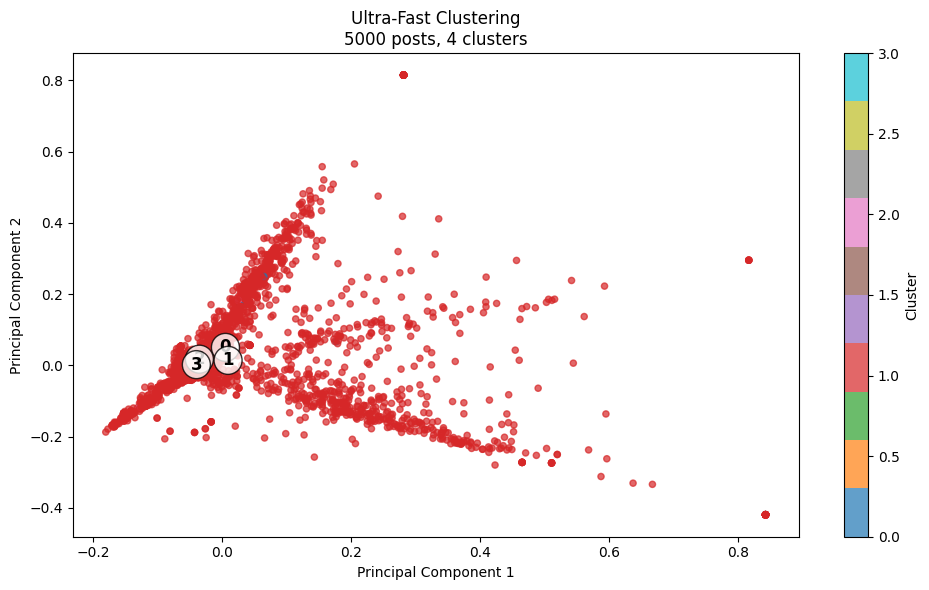


 COMPLETED IN 5.5 SECONDS!
 Cluster distribution:
   Cluster 0: 9 posts (0.2%)
   Cluster 1: 4949 posts (99.0%)
   Cluster 2: 23 posts (0.5%)
   Cluster 3: 19 posts (0.4%)

 Top words per cluster:
   Cluster 0: talking, half, called, just, big
   Cluster 1: like, just, don, people, think
   Cluster 2: good, play, watch, end, work
   Cluster 3: time, best, week, isn, bad
 Saved to 'ultra_fast_clustered_sample.csv'


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import time


start_time = time.time()

# Loading data
csv_file_path = "clustered_data.csv" 
print(" Loading data...")
df = pd.read_csv(csv_file_path)
print(f" Original dataset: {df.shape}")

# Take only a small sample for speed
SAMPLE_SIZE = 5000  #  Only process 5K records
df_small = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)
print(f" Using sample of {len(df_small)} records for speed")

# Find text column quickly
text_column = None
for col in df_small.columns:
    if any(keyword in col.lower() for keyword in ['text', 'content', 'body', 'clean_text', 'message']):
        text_column = col
        break
if text_column is None:
    text_column = df_small.columns[0]  # Use first column as fallback

print(f" Using column: '{text_column}'")

# Quick cleaning
df_small = df_small.dropna(subset=[text_column])
df_small[text_column] = df_small[text_column].fillna('').astype(str)
df_small = df_small[df_small[text_column].str.strip() != '']

print(f" After cleaning: {len(df_small)} documents")

#  VECTORIZATION
print(" vectorization...")
vectorizer = TfidfVectorizer(
    max_features=300,      # ⚡ Very small vocabulary
    stop_words='english',
    min_df=10,             # ⚡ Ignore rare words
    max_df=0.9,
    ngram_range=(1, 1)     # ⚡ Only single words
)
X = vectorizer.fit_transform(df_small[text_column])
print(f" TF-IDF matrix: {X.shape}")

#  CLUSTERING
print("clustering...")
n_clusters = 4 
kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=500,    #  Small batches
    max_iter=50,       #  Fewer iterations
    n_init=3           #  Fewer initializations
)
labels = kmeans.fit_predict(X)
df_small['cluster'] = labels

# Quick top words
print(" Getting top words...")
feature_names = vectorizer.get_feature_names_out()
top_words = {}
for i in range(n_clusters):
    cluster_mask = labels == i
    if cluster_mask.sum() > 0:
        word_scores = np.array(X[cluster_mask].sum(axis=0)).flatten()
        top_indices = word_scores.argsort()[-5:][::-1]  # ⚡ Only top 5 words
        top_words[i] = [feature_names[idx] for idx in top_indices]

#  VISUALIZATION
print("Creating visualization...")
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)

# Simple labels only
for i in range(n_clusters):
    cluster_points = X_2d[labels == i]
    if len(cluster_points) > 0:
        center = cluster_points.mean(axis=0)
        plt.text(center[0], center[1], f'{i}', fontsize=12, weight='bold',
                bbox=dict(boxstyle="circle,pad=0.3", facecolor='white', alpha=0.8))

plt.title(f'Ultra-Fast Clustering\n{len(df_small)} posts, {n_clusters} clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

elapsed = time.time() - start_time
print(f"\n COMPLETED IN {elapsed:.1f} SECONDS!")
print(f" Cluster distribution:")
for i in range(n_clusters):
    count = (labels == i).sum()
    print(f"   Cluster {i}: {count} posts ({count/len(labels)*100:.1f}%)")

print("\n Top words per cluster:")
for i, words in top_words.items():
    print(f"   Cluster {i}: {', '.join(words)}")

# Save the small clustered sample
df_small.to_csv('ultra_fast_clustered_sample.csv', index=False)
print(" Saved to 'ultra_fast_clustered_sample.csv'")

In [3]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print("\n === Cluster Quality Metrics ===")

# Silhouette
sil_score = silhouette_score(X, labels)
print(f" Silhouette Score: {sil_score:.4f}")

# Davies–Bouldin Index
dbi = davies_bouldin_score(X.toarray(), labels)
print(f" Davies-Bouldin Index: {dbi:.4f}")

# Calinski–Harabasz Index
chi = calinski_harabasz_score(X.toarray(), labels)
print(f" Calinski-Harabasz Index: {chi:.2f}")



 === Cluster Quality Metrics ===
 Silhouette Score: 0.0530
 Davies-Bouldin Index: 1.9257
 Calinski-Harabasz Index: 13.27


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize


# ========= LOAD SMALL SAMPLE (CRITICAL) ==========
df = pd.read_csv("clustered_data.csv")

# Take only 3000 rows for speed
df = df.sample(n=min(3000, len(df)), random_state=42)

# Detect text column
text_column = None
for col in df.columns:
    if any(x in col.lower() for x in ['text','content','body','clean','msg']):
        text_column = col
        break
if text_column is None:
    text_column = df.columns[0]

texts = df[text_column].astype(str)


# ========= TF-IDF (fast version) ==========
vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    min_df=3,
    max_df=0.95
)
X = vectorizer.fit_transform(texts)
X = normalize(X)


# ========= K-SELECTION ==========
results = []

for k in range(2, 11):   # only test 2–10
    print(f"Running K={k}...")
    model = KMeans(n_clusters=k, random_state=42, n_init=5)
    labels = model.fit_predict(X)

    sil = silhouette_score(X, labels)
    results.append([k, sil])

# Show results
import pandas as pd
df_results = pd.DataFrame(results, columns=["K", "Silhouette"])
print(df_results)

best_k = df_results.iloc[df_results["Silhouette"].idxmax()]["K"]
print(f"\n✅ Best K = {int(best_k)}")


Running K=2...
Running K=3...
Running K=4...
Running K=5...
Running K=6...
Running K=7...
Running K=8...
Running K=9...
Running K=10...
    K  Silhouette
0   2    0.016542
1   3    0.012736
2   4    0.014507
3   5    0.015594
4   6    0.016465
5   7    0.017198
6   8    0.018369
7   9    0.019789
8  10    0.019562

✅ Best K = 9


In [ ]:
!pip install -q sentence-transformers
#bert
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# ========== 1. Load data ==========
df = pd.read_csv("clustered_data.csv")

# Sample for speed
SAMPLE_SIZE = 5000
df = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)

# Detect text column
text_column = None
for col in df.columns:
    if any(k in col.lower() for k in ['text','content','body','clean','msg']):
        text_column = col
        break
if text_column is None:
    text_column = df.columns[0]

texts = df[text_column].astype(str).tolist()


# ========== 2. Sentence-BERT embeddings ==========
print("Encoding texts with Sentence-BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)

print(f"Embeddings shape: {embeddings.shape}")


# ========== 3. Find best K (Silhouette) ==========
results = []
for k in range(2, 12):
    print(f"Clustering with K={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    
    sil = silhouette_score(embeddings, labels)
    results.append([k, sil])

# Results DataFrame
results_df = pd.DataFrame(results, columns=["K","Silhouette"])
print("\nSilhouette scores by K:")
print(results_df)

best_k = results_df.iloc[results_df["Silhouette"].idxmax()]["K"]
print(f"\n✅ Best K = {int(best_k)}")


# ========== 4. Final clustering with best K ==========
final_kmeans = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
final_labels = final_kmeans.fit_predict(embeddings)
df['cluster'] = final_labels

# Save clustered sample
df.to_csv("sbert_clustered_sample.csv", index=False)
print("Saved clustered sample to 'sbert_clustered_sample.csv'")


g:\CSE445_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Encoding texts with Sentence-BERT...


g:\CSE445_Project\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HT

Embeddings shape: (5000, 384)
Clustering with K=2...
Clustering with K=3...
Clustering with K=4...
Clustering with K=5...
Clustering with K=6...
Clustering with K=7...
Clustering with K=8...
Clustering with K=9...
Clustering with K=10...
Clustering with K=11...

Silhouette scores by K:
    K  Silhouette
0   2    0.018617
1   3    0.019786
2   4    0.025065
3   5    0.025586
4   6    0.026560
5   7    0.025619
6   8    0.027308
7   9    0.026391
8  10    0.027778
9  11    0.026542

✅ Best K = 10
Saved clustered sample to 'sbert_clustered_sample.csv'


In [9]:
! pip install --upgrade pip setuptools wheel


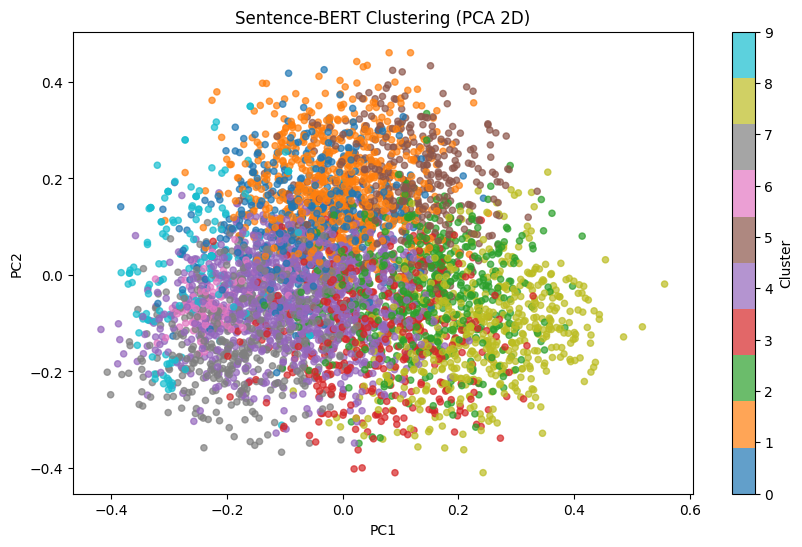

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=df['cluster'], cmap='tab10', s=20, alpha=0.7)
plt.title("Sentence-BERT Clustering (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


In [13]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity

# Optional: HDBSCAN
try:
    import hdbscan
    hdbscan_available = True
except:
    hdbscan_available = False
    print("HDBSCAN not installed. Skipping HDBSCAN clustering.")

# ========== 1. Load data ==========
df = pd.read_csv("clustered_data.csv")
SAMPLE_SIZE = 3000
df = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)

# Detect text column
text_column = None
for col in df.columns:
    if any(k in col.lower() for k in ['text','content','body','clean','msg']):
        text_column = col
        break
if text_column is None:
    text_column = df.columns[0]

texts = df[text_column].astype(str).tolist()

# ========== 2. Sentence-BERT embeddings ==========
print("Encoding texts with Sentence-BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
print(f"Embeddings shape: {embeddings.shape}")

# ========== 3. Helper functions ==========
def cosine_intra_inter(labels, embeddings):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    intra_sim = []
    centroids = []
    
    for i in range(n_clusters):
        cluster_points = embeddings[labels == i]
        if len(cluster_points) > 1:
            sim_matrix = cosine_similarity(cluster_points)
            n = len(cluster_points)
            avg_sim = (np.sum(sim_matrix) - n) / (n*(n-1))
            intra_sim.append(avg_sim)
        else:
            intra_sim.append(1.0)
        centroids.append(cluster_points.mean(axis=0))
    
    centroids = np.array(centroids)
    inter_sim_matrix = cosine_similarity(centroids)
    n = n_clusters
    inter_sim = (np.sum(inter_sim_matrix) - n) / (n*(n-1)) if n > 1 else 0
    
    return np.mean(intra_sim), inter_sim

def evaluate_model(name, labels, embeddings):
    result = {"Model": name}
    # Exclude noise for silhouette if using HDBSCAN/DBSCAN
    if -1 in labels:
        mask = labels != -1
        sil = silhouette_score(embeddings[mask], labels[mask]) if mask.sum() > 1 else np.nan
    else:
        sil = silhouette_score(embeddings, labels)
    dbi = davies_bouldin_score(embeddings, labels)
    chi = calinski_harabasz_score(embeddings, labels)
    intra, inter = cosine_intra_inter(labels, embeddings)
    
    result.update({
        "Silhouette": sil,
        "Davies-Bouldin": dbi,
        "Calinski-Harabasz": chi,
        "Cosine Intra": intra,
        "Cosine Inter": inter
    })
    return result

# ========== 4. Run models ==========
results = []
n_clusters = 10  # you can adjust based on previous analysis

# 4a. KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)
results.append(evaluate_model("KMeans", labels, embeddings))

# 4b. Agglomerative
agg = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')

labels = agg.fit_predict(embeddings)
results.append(evaluate_model("Agglomerative", labels, embeddings))

# 4c. Gaussian Mixture
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
labels = gmm.fit_predict(embeddings)
results.append(evaluate_model("GaussianMixture", labels, embeddings))

# 4d. HDBSCAN (optional)
if hdbscan_available:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=30, metric='euclidean')
    labels = clusterer.fit_predict(embeddings)
    results.append(evaluate_model("HDBSCAN", labels, embeddings))

# ========== 5. Results summary ==========
df_results = pd.DataFrame(results)
print("\nClustering Metrics Comparison:")
print(df_results)


HDBSCAN not installed. Skipping HDBSCAN clustering.
Encoding texts with Sentence-BERT...


Batches: 100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


Embeddings shape: (3000, 384)

Clustering Metrics Comparison:
             Model  Silhouette  Davies-Bouldin  Calinski-Harabasz  \
0           KMeans    0.026078        4.774310          35.375290   
1    Agglomerative    0.011630        5.592162          18.506863   
2  GaussianMixture    0.026078        4.774310          35.375290   

   Cosine Intra  Cosine Inter  
0      0.193233      0.271298  
1      0.152365      0.238678  
2      0.193233      0.271298  


PCA 2D shape: (3000, 2)


C:\Users\User\AppData\Local\Temp\ipykernel_224300\3437793893.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


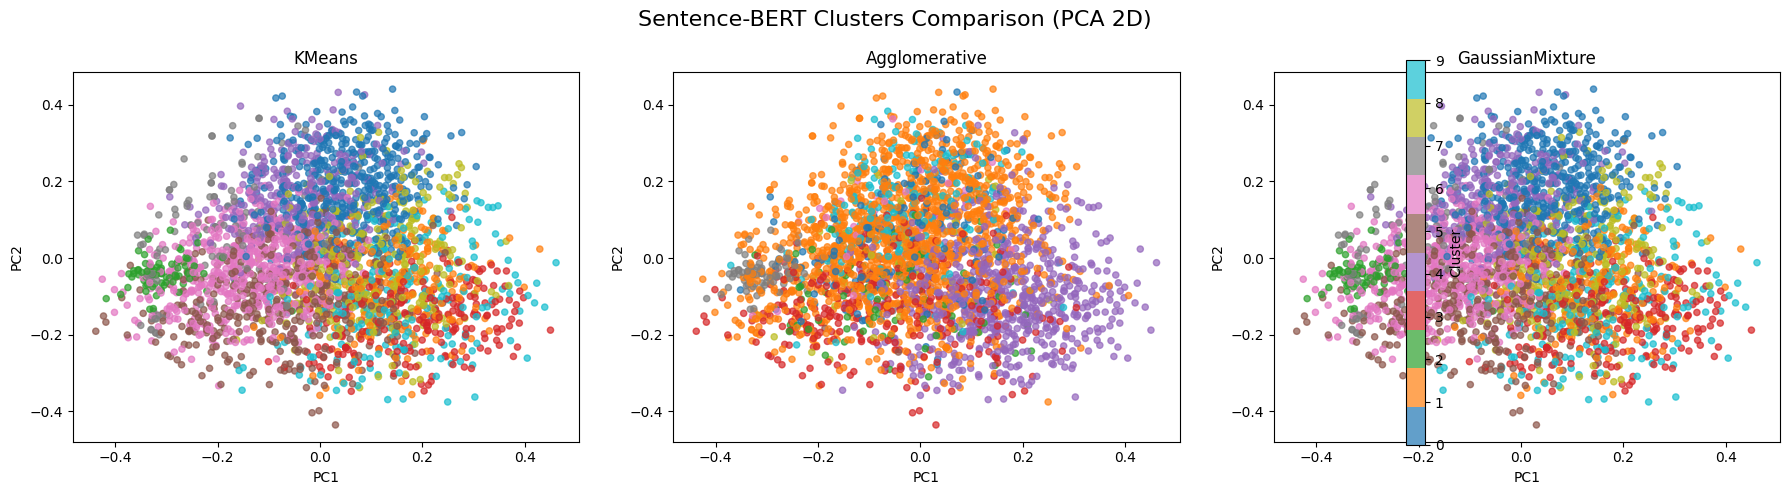

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Models and labels
models = {
    "KMeans": kmeans.fit_predict(embeddings),
    "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average').fit_predict(embeddings),
    "GaussianMixture": GaussianMixture(n_components=n_clusters, random_state=42).fit_predict(embeddings)
}

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(embeddings)
print(f"PCA 2D shape: {X_2d.shape}")

# Plot settings
fig, axes = plt.subplots(1, len(models), figsize=(18, 5))
if len(models) == 1:
    axes = [axes]

for ax, (name, labels) in zip(axes, models.items()):
    scatter = ax.scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=labels, cmap='tab10',
        alpha=0.7, s=20
    )
    ax.set_title(name)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# Shared colorbar
fig.colorbar(scatter, ax=axes, orientation='vertical', label='Cluster')
plt.suptitle("Sentence-BERT Clusters Comparison (PCA 2D)", fontsize=16)
plt.tight_layout()
plt.show()


 TREND DETECTION WITH  DATASET
  dataset shape: (1017100, 4)
 Columns: ['text', 'source', 'clean_text', 'cluster']
 Using text column: 'clean_text'
Using sample of 10,000 posts for faster analysis

 ANALYZING TRENDS IN YOUR DATASET...
   After cleaning: 8789 valid posts
Analyzing text patterns...
   Vocabulary size: 800 terms
 Clustering for trend discovery...
 TRENDS FOUND : 

1.  Sports & Events
    Volume: 1046 posts (11.9% of data)
    Key Terms: want, ive
    Engagement Score: 3.0/10
    Sample Discussions:
      1. because the fact that we waste our time with their nonsense asylum claims is bullshit already name a country in central ...
      2. she wasnt then except locally at that point she was just the presidents wife which leads to something else ive noticed d...

2.  Personal Stories
    Volume: 639 posts (7.3% of data)
    Key Terms: looks, feel
    Engagement Score: 1.8/10
    Sample Discussions:
      1. we just dont know we dont have clear evidence of what that progressi

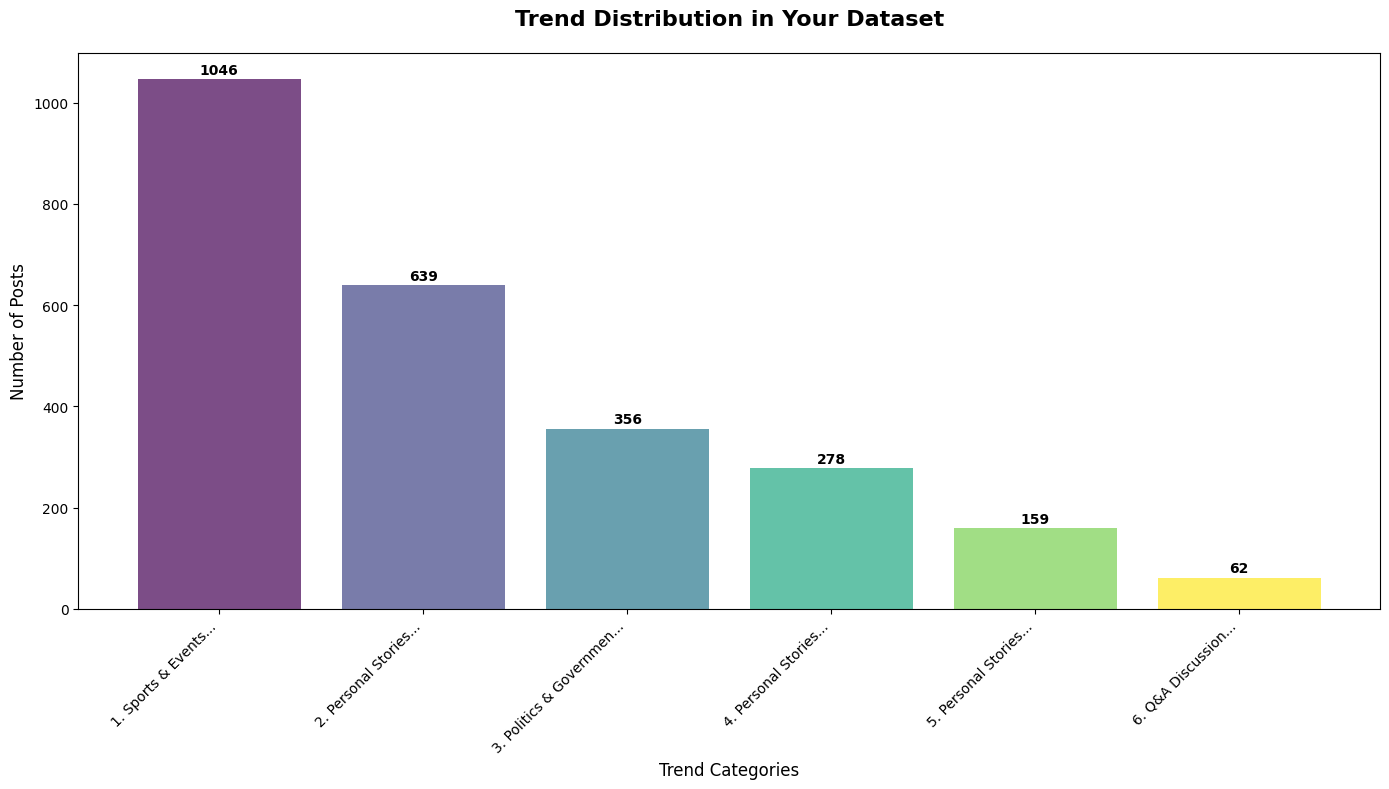


 SAMPLE OF RAW DATA (first 3 posts):
--------------------------------------------------
1. your dog looks very similar to my dog how old is your dog...
2. your chemistry puns are so basic...
3. because the fact that we waste our time with their nonsense asylum claims is bullshit already name a country in central and south america that you per...


In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print(" TREND DETECTION WITH  DATASET")
print("=" * 60)

# Load YOUR dataset - UPDATE THIS PATH
df = pd.read_csv('clustered_data.csv')  # ⚠️ CHANGE TO YOUR ACTUAL FILE PATH

print(f"  dataset shape: {df.shape}")
print(f" Columns: {df.columns.tolist()}")

# Auto-detect the text column
text_column = None
text_candidates = ['clean_text', 'text', 'body', 'content', 'message', 'tweet', 'post', 'comment']

for candidate in text_candidates:
    if candidate in df.columns:
        text_column = candidate
        break

if text_column is None:
    # Use first string column
    string_cols = df.select_dtypes(include=['object']).columns
    text_column = string_cols[0] if len(string_cols) > 0 else df.columns[0]

print(f" Using text column: '{text_column}'")

# Sample your data for faster processing (adjust based on your dataset size)
if len(df) > 10000:
    df_analysis = df.sample(n=10000, random_state=42)
    print(f"Using sample of 10,000 posts for faster analysis")
else:
    df_analysis = df.copy()
    print(f" Using all {len(df)} posts")

def extract_real_trends(df, text_column, n_trends=8):
    """
    Extract actual meaningful trends 
    """
   
    
    # Clean the text data
    texts = df[text_column].fillna('').astype(str)
    
    # Remove very short texts and clean
    cleaned_texts = []
    for text in texts:
        if len(text.strip()) > 25:  # Only keep meaningful length texts
            # Basic cleaning
            text = re.sub(r'http\S+', '', text)  # Remove URLs
            text = re.sub(r'@\w+', '', text)     # Remove mentions
            text = re.sub(r'[^\w\s]', ' ', text) # Remove special chars
            text = ' '.join(text.split())        # Remove extra spaces
            cleaned_texts.append(text.lower())
    
    print(f"   After cleaning: {len(cleaned_texts)} valid posts")
    
    # Use TF-IDF with focus on specific terms (not generic words)
    print("Analyzing text patterns...")
    vectorizer = TfidfVectorizer(
        max_features=800,
        stop_words='english',
        min_df=5,           # Ignore very rare terms
        max_df=0.4,         # Ignore overly common terms (more aggressive)
        ngram_range=(1, 2), # Include phrases
        analyzer='word'
    )
    
    X = vectorizer.fit_transform(cleaned_texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"   Vocabulary size: {len(feature_names)} terms")
    
    # Cluster to find trends
    print(" Clustering for trend discovery...")
    kmeans = KMeans(n_clusters=n_trends, random_state=42, n_init=5)
    cluster_labels = kmeans.fit_predict(X)
    
    # Analyze each cluster for trends
    trends = []
    
    for cluster_id in range(n_trends):
        cluster_mask = cluster_labels == cluster_id
        cluster_texts = [cleaned_texts[i] for i in range(len(cleaned_texts)) if cluster_labels[i] == cluster_id]
        
        if len(cluster_texts) > 10:  # Only consider substantial clusters
            # Get top keywords with better filtering
            word_scores = np.array(X[cluster_mask].sum(axis=0)).flatten()
            top_indices = word_scores.argsort()[-20:][::-1]  # Get more words for context
            raw_keywords = [feature_names[idx] for idx in top_indices]
            
            # Filter out generic words and get meaningful keywords
            meaningful_keywords = filter_meaningful_keywords(raw_keywords, cluster_texts)
            
            if meaningful_keywords:  # Only if we found meaningful keywords
                trend_topic = identify_trend_topic(meaningful_keywords, cluster_texts)
                
                trends.append({
                    'trend_id': cluster_id,
                    'topic': trend_topic,
                    'size': len(cluster_texts),
                    'percentage': (len(cluster_texts) / len(cleaned_texts)) * 100,
                    'keywords': meaningful_keywords[:8],  # Top 8 meaningful keywords
                    'sample_posts': cluster_texts[:3],    # Sample posts for context
                    'engagement_score': calculate_engagement(cluster_texts)
                })
    
    # Sort by size (most popular trends first)
    return sorted(trends, key=lambda x: x['size'], reverse=True)

def filter_meaningful_keywords(keywords, texts):
    """
    Filter out generic words to find meaningful trend indicators
    """
    # Common generic words that don't indicate specific trends
    generic_words = {
        'like', 'just', 'know', 'think', 'people', 'really', 'would', 'could', 
        'should', 'dont', 'cant', 'wont', 'get', 'got', 'see', 'look', 'said',
        'say', 'make', 'made', 'time', 'good', 'great', 'bad', 'better', 'best',
        'right', 'wrong', 'way', 'thing', 'things', 'stuff', 'something', 'anything',
        'maybe', 'probably', 'actually', 'literally', 'basically', 'seriously'
    }
    
    # Filter and score keywords
    meaningful = []
    for keyword in keywords:
        if (keyword not in generic_words and 
            len(keyword) > 2 and 
            not keyword.isdigit()):
            
            # Check if this keyword appears in multiple posts (indicates trend)
            keyword_count = sum(1 for text in texts if keyword in text.lower())
            if keyword_count > len(texts) * 0.1:  # Appears in at least 10% of cluster
                meaningful.append(keyword)
    
    return meaningful[:15]  # Return top 15 meaningful keywords

def identify_trend_topic(keywords, texts):
    """
    Identify what kind of trend this cluster represents
    """
    all_text = ' '.join(texts).lower()
    keyword_str = ' '.join(keywords).lower()
    
    # Trend categories with specific indicators
    categories = {
        'Politics & Government': [
            'trump', 'biden', 'president', 'election', 'government', 'senate', 'congress',
            'vote', 'law', 'policy', 'democrat', 'republican', 'administration', 'bill'
        ],
        'Entertainment & Movies': [
            'movie', 'film', 'marvel', 'disney', 'netflix', 'actor', 'director',
            'trailer', 'scene', 'character', 'plot', 'cinema', 'hollywood', 'oscar'
        ],
        'Gaming & Esports': [
            'game', 'gaming', 'player', 'playstation', 'xbox', 'nintendo', 'steam',
            'fortnite', 'minecraft', 'cod', 'level', 'character', 'multiplayer', 'console'
        ],
        'Technology & Apps': [
            'iphone', 'android', 'apple', 'google', 'facebook', 'twitter', 'instagram',
            'app', 'update', 'software', 'phone', 'tech', 'feature', 'device', 'computer'
        ],
        'Sports & Events': [
            'game', 'team', 'player', 'season', 'win', 'score', 'nfl', 'nba', 'mlb',
            'soccer', 'football', 'basketball', 'baseball', 'championship', 'tournament'
        ],
        'Social Issues': [
            'climate', 'environment', 'health', 'education', 'justice', 'rights',
            'equality', 'protest', 'movement', 'change', 'future', 'society', 'community'
        ],
        'Personal Stories': [
            'experience', 'story', 'life', 'family', 'friend', 'relationship',
            'work', 'job', 'school', 'home', 'parent', 'child', 'love'
        ],
        'Pop Culture': [
            'celebrity', 'famous', 'star', 'music', 'artist', 'album', 'song',
            'youtube', 'tiktok', 'influencer', 'viral', 'trending', 'meme'
        ]
    }
    
    # Score each category
    scores = {}
    for category, markers in categories.items():
        score = sum(1 for marker in markers if marker in keyword_str or marker in all_text)
        scores[category] = score
    
    # Get best matching category
    best_category = max(scores, key=scores.get)
    best_score = scores[best_category]
    
    # If no clear category, try to infer from keywords
    if best_score < 2:
        return infer_topic_from_keywords(keywords)
    else:
        return best_category

def infer_topic_from_keywords(keywords):
    """Infer topic when no clear category matches"""
    keyword_str = ' '.join(keywords).lower()
    
    if any(word in keyword_str for word in ['movie', 'film', 'show', 'actor']):
        return "Entertainment Discussion"
    elif any(word in keyword_str for word in ['game', 'play', 'player', 'win']):
        return "Gaming Discussion"
    elif any(word in keyword_str for word in ['phone', 'app', 'update', 'tech']):
        return "Technology Talk"
    elif any(word in keyword_str for word in ['time', 'day', 'week', 'year']):
        return "Current Events"
    elif any(word in keyword_str for word in ['question', 'help', 'advice', 'suggest']):
        return "Q&A Discussion"
    else:
        # Create a descriptive name from top keywords
        return f"Discussion about {', '.join(keywords[:2])}"

def calculate_engagement(texts):
    """Simple engagement metric based on text characteristics"""
    if not texts:
        return 0
    
    avg_length = np.mean([len(text.split()) for text in texts])
    question_count = sum(1 for text in texts if '?' in text)
    exclamation_count = sum(1 for text in texts if '!' in text)
    
    # Simple scoring (0-10)
    score = min(10, (avg_length / 15) + (question_count / len(texts) * 3) + (exclamation_count / len(texts) * 2))
    return round(score, 1)

# EXECUTE THE TREND ANALYSIS
print("\n ANALYZING TRENDS IN YOUR DATASET...")
trends = extract_real_trends(df_analysis, text_column, n_trends=8)


print(" TRENDS FOUND : ")


if not trends:
    print(" No clear trends detected. data might be too generic or need different processing.")
else:
    for i, trend in enumerate(trends, 1):
        print(f"\n{i}.  {trend['topic']}")
        print(f"    Volume: {trend['size']} posts ({trend['percentage']:.1f}% of data)")
        print(f"    Key Terms: {', '.join(trend['keywords'][:5])}")
        print(f"    Engagement Score: {trend['engagement_score']}/10")
        
       
        if trend['sample_posts']:
            print(f"    Sample Discussions:")
            for j, post in enumerate(trend['sample_posts'][:2], 1):
                preview = post[:120] + "..." if len(post) > 120 else post
                print(f"      {j}. {preview}")

    # Summary statistics
    print(f"\n TREND ANALYSIS SUMMARY:")
    print(f"   Total trends identified: {len(trends)}")
    print(f"   Most popular trend: '{trends[0]['topic']}' ({trends[0]['percentage']:.1f}% of posts)")
    print(f"   Total posts analyzed: {len(df_analysis)}")
    
    # Visualization
    plt.figure(figsize=(14, 8))
    trend_names = [f"{i+1}. {trend['topic'][:20]}..." for i, trend in enumerate(trends)]
    trend_sizes = [trend['size'] for trend in trends]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(trends)))
    bars = plt.bar(trend_names, trend_sizes, color=colors, alpha=0.7)
    
    plt.title('Trend Distribution in Your Dataset', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Trend Categories', fontsize=12)
    plt.ylabel('Number of Posts', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, size in zip(bars, trend_sizes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{size}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Additional: Show raw data sample for context
print(f"\n SAMPLE OF RAW DATA (first 3 posts):")
print("-" * 50)
for i in range(min(3, len(df_analysis))):
    text_preview = str(df_analysis.iloc[i][text_column])[:150] + "..." 
    print(f"{i+1}. {text_preview}")

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
from collections import Counter

print(" TREND DETECTION WITH STABILITY VALIDATION")
print("=" * 60)

# Load your dataset
df = pd.read_csv('clustered_data.csv')  

# Auto-detect text column
text_column = 'clean_text' if 'clean_text' in df.columns else df.columns[0]
print(f" Dataset: {df.shape}, Text column: '{text_column}'")

def robust_trend_analysis(df, text_column, sample_size=8000, n_clusters=8, n_validation_runs=3):
    """
    Robust trend analysis with multiple validation checks
    """
    
   
    if len(df) > sample_size:
        df_analysis = df.sample(n=sample_size, random_state=42)
        print(f"Using sample of {sample_size} posts")
    else:
        df_analysis = df.copy()
        print(f" Using all {len(df)} posts")
    
    # MAIN ANALYSIS on primary sample
    print("\n MAIN TREND ANALYSIS...")
    main_trends, X, feature_names = extract_trends_with_metrics(df_analysis, text_column, n_clusters)
    
    # STABILITY VALIDATION
    print("\n STABILITY VALIDATION...")
    stability_results = validate_trend_stability(df, text_column, n_runs=n_validation_runs)
    
    return main_trends, stability_results

def extract_trends_with_metrics(df, text_column, n_clusters):
 
    
    # Clean and vectorize
    texts = clean_texts(df[text_column])
    vectorizer = TfidfVectorizer(max_features=800, stop_words='english', min_df=5, max_df=0.4)
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Cluster with quality assessment
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
    labels = kmeans.fit_predict(X)
    
    # Calculate clustering quality
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else 0
    
    print(f" Clustering Quality:")
    print(f"   - Silhouette Score: {silhouette:.3f}")
    print(f"   - Cluster balance: {np.std(np.bincount(labels)):.1f} (lower = more balanced)")
    
    # Extract trends
    trends = []
    for cluster_id in range(n_clusters):
        cluster_mask = labels == cluster_id
        cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster_id]
        
        if len(cluster_texts) > len(texts) * 0.05:  # At least 5% of data
            trends.append(analyze_cluster_trend(cluster_id, cluster_texts, X, cluster_mask, feature_names))
    
    return sorted(trends, key=lambda x: x['size'], reverse=True), X, feature_names

def validate_trend_stability(df, text_column, n_runs=3, sample_size=4000):
    
    
    consistent_trends = Counter()
    
    for run in range(n_runs):
        df_sample = df.sample(n=min(sample_size, len(df)), random_state=run)
        texts = clean_texts(df_sample[text_column])
        
        if len(texts) > 100:  # Only run if we have enough data
            vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
            X = vectorizer.fit_transform(texts)
            
            kmeans = KMeans(n_clusters=6, random_state=run, n_init=3)
            labels = kmeans.fit_predict(X)
            
            # Simple trend detection for validation
            for cluster_id in range(6):
                cluster_mask = labels == cluster_id
                if cluster_mask.sum() > len(texts) * 0.1:  # Substantial cluster
                    cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster_id]
                    trend_topic = identify_trend_topic_simple(cluster_texts)
                    consistent_trends[trend_topic] += 1
    
    print(" Trends found across multiple runs:")
    for trend, count in consistent_trends.most_common():
        if count > 1:  
            print(f"    {trend}: {count}/{n_runs} runs")
    
    return consistent_trends

def identify_trend_topic_simple(texts):
    all_text = ' '.join(texts).lower()
    
    categories = {
        'Politics': ['trump', 'biden', 'election', 'government', 'president'],
        'Entertainment': ['movie', 'film', 'show', 'actor', 'character'],
        'Gaming': ['game', 'player', 'play', 'win', 'level'],
        'Technology': ['phone', 'app', 'update', 'tech', 'computer'],
        'Sports': ['game', 'team', 'player', 'win', 'season'],
        'Social': ['people', 'life', 'time', 'friend', 'family']
    }
    
    for category, keywords in categories.items():
        if any(keyword in all_text for keyword in keywords):
            return category
    
    return 'General Discussion'

def clean_texts(text_series):
    """Clean text data"""
    texts = []
    for text in text_series.fillna('').astype(str):
        if len(text.strip()) > 25:
            text = re.sub(r'http\S+', '', text)
            text = re.sub(r'[^\w\s]', ' ', text)
            text = ' '.join(text.split())
            texts.append(text.lower())
    return texts

def analyze_cluster_trend(cluster_id, cluster_texts, X, cluster_mask, feature_names):
    """Analyze a single cluster for trends"""
    word_scores = np.array(X[cluster_mask].sum(axis=0)).flatten()
    top_indices = word_scores.argsort()[-15:][::-1]
    raw_keywords = [feature_names[idx] for idx in top_indices]
    
    meaningful_keywords = [kw for kw in raw_keywords if kw not in 
                          {'like', 'just', 'know', 'think', 'people', 'really'}]
    
    trend_topic = identify_trend_topic_simple(cluster_texts)
    
    return {
        'trend_id': cluster_id,
        'topic': trend_topic,
        'size': len(cluster_texts),
        'keywords': meaningful_keywords[:6],
        'sample_posts': cluster_texts[:2]
    }

#  ROBUST ANALYSIS
print(" TREND ANALYSIS...")
main_trends, stability_results = robust_trend_analysis(df, text_column)


print("FINAL TREND REPORT")


for i, trend in enumerate(main_trends, 1):
    print(f"\n{i}. {trend['topic']}")
    print(f"    {trend['size']} posts | Keywords: {', '.join(trend['keywords'][:4])}")
    if trend['sample_posts']:
        print(f"    Sample: {trend['sample_posts'][0][:100]}...")

 TREND DETECTION WITH STABILITY VALIDATION
 Dataset: (1017100, 4), Text column: 'clean_text'
 TREND ANALYSIS...
Using sample of 8000 posts

 MAIN TREND ANALYSIS...
 Clustering Quality:
   - Silhouette Score: 0.025
   - Cluster balance: 1570.4 (lower = more balanced)

 STABILITY VALIDATION...
 Trends found across multiple runs:
    Politics: 5/3 runs
FINAL TREND REPORT

1. Politics
    5003 posts | Keywords: im, time, thats, good
    Sample: your dog looks very similar to my dog how old is your dog...

2. Politics
    579 posts | Keywords: im, good, game, doesnt
    Sample: she wasnt then except locally at that point she was just the presidents wife which leads to somethin...

3. Politics
    473 posts | Keywords: looks, look, feel, im
    Sample: id also like to propose we start using beacons for longdistance communition...

4. Politics
    460 posts | Keywords: dont, want, im, youre
    Sample: we just dont know we dont have clear evidence of what that progression would look like they

g:\CSE445_Project\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular H


===== KMeans Clustering Metrics =====
Silhouette Score: 0.06157148256897926
Davies-Bouldin: 3.2510201638825706
Calinski-Harabasz: 103.44256591796875



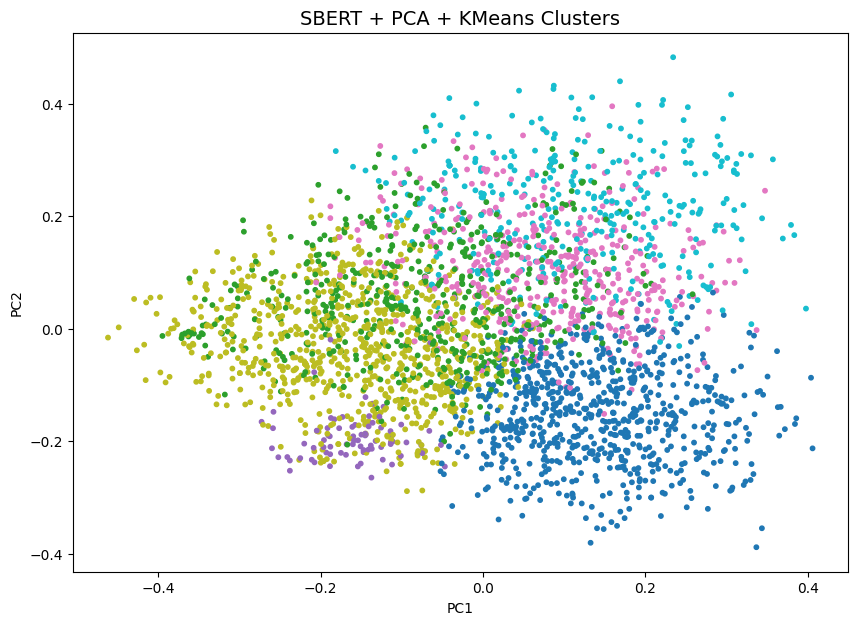

In [20]:
# ============================================================
# IMPROVED TEXT CLUSTERING PIPELINE (Python 3.14 Compatible)
# SBERT + PCA + KMeans + Full Metrics + Visualization
# ============================================================

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
import matplotlib.pyplot as plt

# -------------------------
# 1. Load Data
# -------------------------
texts = df['text'].astype(str).tolist()

# -------------------------
# 2. Strong SBERT embeddings
# -------------------------
model = SentenceTransformer("all-mpnet-base-v2")

emb = model.encode(
    texts,
    normalize_embeddings=True,   # L2 normalization built-in
    show_progress_bar=True
)

# -------------------------
# 3. PCA to 50D
# -------------------------
pca = PCA(n_components=50, random_state=42)
X_50 = pca.fit_transform(emb)

# -------------------------
# 4. KMeans Clustering
# -------------------------
k = 6   # choose k based on your elbow curve
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_50)

# -------------------------
# 5. Evaluation
# -------------------------
sil = silhouette_score(X_50, labels)
db = davies_bouldin_score(X_50, labels)
ch = calinski_harabasz_score(X_50, labels)

print("\n===== KMeans Clustering Metrics =====")
print("Silhouette Score:", sil)
print("Davies-Bouldin:", db)
print("Calinski-Harabasz:", ch)
print("=====================================\n")

# -------------------------
# 6. PCA 2D for Visualization
# -------------------------
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(emb)

plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="tab10", s=10)
plt.title("SBERT + PCA + KMeans Clusters", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# -------------------------
# 7. Save Results
# -------------------------
df["cluster"] = labels
df.to_csv("clustered_kmeans_output.csv", index=False)


K=2, Silhouette Score=0.0055
K=3, Silhouette Score=0.0043
K=4, Silhouette Score=0.0055
K=5, Silhouette Score=0.0048
K=6, Silhouette Score=0.0079
K=7, Silhouette Score=0.0039
K=8, Silhouette Score=0.0104
K=9, Silhouette Score=0.0108
K=10, Silhouette Score=0.0101

Optimal number of clusters: 9
Best Silhouette Score: 0.0108


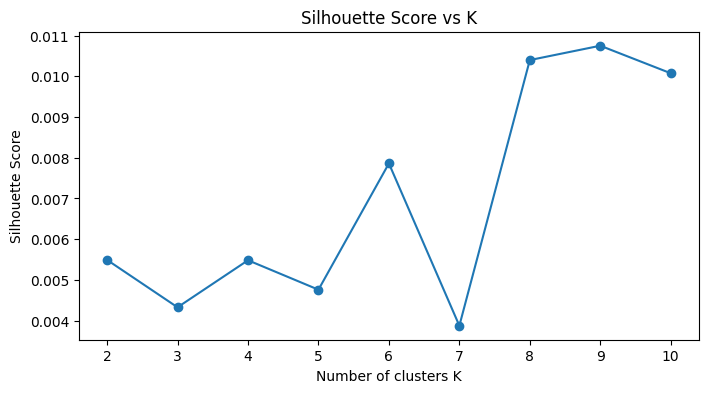

In [31]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../dataset/combined_cleaned_social_media.csv")
texts = df['text'].astype(str)

# Convert text to TF-IDF vectors (sparse)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(texts)  # sparse matrix, memory efficient

# Find best K using silhouette score
best_k = 2
best_score = -1
sil_scores = []

for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(X)  # works directly with sparse matrix
    score = silhouette_score(X, labels, sample_size=10000, random_state=42)  
    # sample_size avoids computing huge distance matrix
    sil_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
        best_model = kmeans

print(f"\nOptimal number of clusters: {best_k}")
print(f"Best Silhouette Score: {best_score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel("Number of clusters K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.show()

# Add cluster labels to dataframe
df['cluster'] = best_labels


K=2, Silhouette Score=0.1278
K=3, Silhouette Score=0.1312
K=4, Silhouette Score=0.1058
K=5, Silhouette Score=0.1151
K=6, Silhouette Score=0.1123
K=7, Silhouette Score=0.1056
K=8, Silhouette Score=0.0895
K=9, Silhouette Score=0.1110
K=10, Silhouette Score=0.1205

Optimal number of clusters: 3
Best Silhouette Score: 0.1312


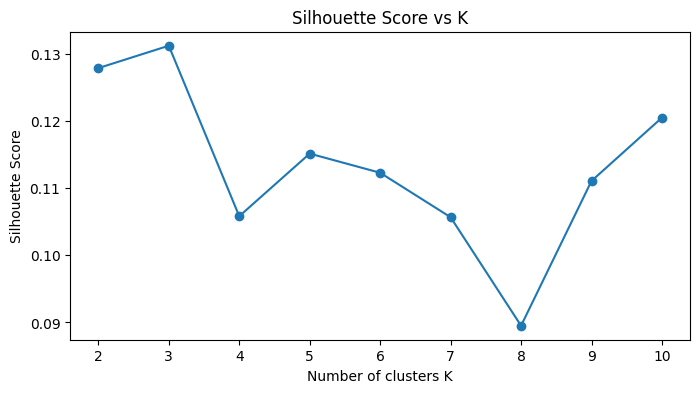

In [32]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../dataset/combined_cleaned_social_media.csv")
texts = df['text'].astype(str)

# TF-IDF vectorization (sparse)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(texts)

# Dimensionality reduction using TruncatedSVD (LSA)
svd = TruncatedSVD(n_components=100, random_state=42)  # adjust n_components for memory/speed
X_reduced = svd.fit_transform(X)  # still much smaller than dense PCA

# Find best K using silhouette score
best_k = 2
best_score = -1
sil_scores = []

for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels, sample_size=10000, random_state=42)
    sil_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
        best_model = kmeans

print(f"\nOptimal number of clusters: {best_k}")
print(f"Best Silhouette Score: {best_score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel("Number of clusters K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.show()

# Add cluster labels to dataframe
df['cluster'] = best_labels


In [33]:
import numpy as np

# Number of top words per cluster
top_n = 10

# Get feature names from TF-IDF
feature_names = vectorizer.get_feature_names_out()

# If using TruncatedSVD, cluster centers are in reduced space, so we need to approximate keywords
# Transform SVD components back to TF-IDF space
original_space_centers = svd.inverse_transform(best_model.cluster_centers_)

for i, center in enumerate(original_space_centers):
    top_indices = center.argsort()[::-1][:top_n]
    top_features = [feature_names[j] for j in top_indices]
    print(f"\nCluster {i} top words: {', '.join(top_features)}")



Cluster 0 top words: like, just, don, people, think, know, good, time, did, really

Cluster 1 top words: right, just, know, like, think, left, people, don, fucking, ll

Cluster 2 top words: shit, got, just, holy, like, ve, don, people, good, fuck


In [37]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your dataset
df = pd.read_csv("../dataset/combined_cleaned_social_media.csv")
texts = df['text'].astype(str)

# Step 1: Convert text to embeddings (memory-efficient)
print("Generating embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True)

# Step 2: Determine best K using silhouette score
best_score = -1
best_k = 2
best_labels = None
sil_scores = []

print("Finding optimal number of clusters...")
for k in range(2, 11):  # try K = 2 to 10
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels, sample_size=10000, random_state=42)
    sil_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
        best_model = kmeans

print(f"\nOptimal number of clusters: {best_k}")
print(f"Best Silhouette Score: {best_score:.4f}")

# Step 3: Assign cluster labels to dataframe
df['cluster'] = best_labels

# Step 4: Extract top keywords per cluster
print("Extracting top keywords per cluster...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()
top_n = 10

for c in range(best_k):
    cluster_indices = np.where(df['cluster'] == c)[0]
    cluster_tfidf = X_tfidf[cluster_indices]
    mean_tfidf = cluster_tfidf.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    top_features = [feature_names[i] for i in top_indices]
    print(f"\nCluster {c} top words: {', '.join(top_features)}")

# Step 5: Show top documents per cluster
top_docs = 3  # top 3 docs per cluster
for c in range(best_k):
    cluster_indices = np.where(df['cluster'] == c)[0]
    cluster_embeddings = embeddings[cluster_indices]
    # Find documents closest to cluster centroid
    centroid = best_model.cluster_centers_[c]
    distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
    top_doc_indices = distances.argsort()[:top_docs]
    print(f"\nCluster {c} top documents:")
    for idx in top_doc_indices:
        doc_idx = cluster_indices[idx]
        print(df.iloc[doc_idx]['text'][:200], "...\n")  # print first 200 chars


Generating embeddings...


Batches: 100%|██████████| 15893/15893 [1:49:28<00:00,  2.42it/s] 


Finding optimal number of clusters...
K=2, Silhouette Score=0.0176
K=3, Silhouette Score=0.0197
K=4, Silhouette Score=0.0189
K=5, Silhouette Score=0.0215
K=6, Silhouette Score=0.0225
K=7, Silhouette Score=0.0261
K=8, Silhouette Score=0.0273
K=9, Silhouette Score=0.0274
K=10, Silhouette Score=0.0269

Optimal number of clusters: 9
Best Silhouette Score: 0.0274
Extracting top keywords per cluster...

Cluster 0 top words: just, like, movie, episode, think, arya, jon, did, really, time

Cluster 1 top words: не, на, что, это, как, то, так, но, по, ты

Cluster 2 top words: just, game, like, ll, play, good, got, don, thanks, time

Cluster 3 top words: game, like, just, team, good, think, don, play, lol, year

Cluster 4 top words: like, love, look, just, looks, good, don, know, lol, oh

Cluster 5 top words: just, like, don, people, know, think, want, time, really, say

Cluster 6 top words: people, just, don, like, trump, think, gt, right, know, did

Cluster 7 top words: reddit, message, com, ht

In [8]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import warnings
warnings.filterwarnings('ignore')

print("Starting IMPROVED trend analysis...")
start_time = time.time()

# Load data
df = pd.read_csv("../dataset/combined_cleaned_social_media.csv")
texts = df['text'].astype(str).tolist()
print(f"Total documents: {len(texts)}")

# Sample for processing
SAMPLE_SIZE = 50000
if len(texts) > SAMPLE_SIZE:
    print(f"Sampling {SAMPLE_SIZE} documents...")
    sampled_indices = np.random.choice(len(texts), SAMPLE_SIZE, replace=False)
    texts = [texts[i] for i in sampled_indices]
    df_sample = df.iloc[sampled_indices].copy()
else:
    df_sample = df.copy()

# ========== ENHANCED PREPROCESSING ==========
print("\n" + "="*60)
print("ENHANCED PREPROCESSING")
print("="*60)

def advanced_preprocess(text):
    """Advanced preprocessing focusing on meaningful content"""
    if not isinstance(text, str):
        return None, []
    
    original_text = text
    text = text.lower()
    
    # Extract hashtags and mentions
    hashtags = re.findall(r'#(\w+)', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    # Remove user mentions (@username)
    text = re.sub(r'@\w+', ' ', text)
    
    # Remove common bot patterns
    bot_phrases = [
        'i am a bot', 'action was performed', 'please contact',
        'subreddit', 'moderator', 'your post has been',
        'upvote this comment', 'downvote this comment'
    ]
    
    for phrase in bot_phrases:
        if phrase in text:
            return None, []
    
    # Keep hashtag text but remove # symbol
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove punctuation except for some
    text = re.sub(r'[^\w\s!?]', ' ', text)
    
    # Remove standalone numbers (except years)
    text = re.sub(r'\b(?!19\d{2}|20\d{2})\d+\b', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Check if text is meaningful (at least 4 words)
    words = text.split()
    if len(words) < 4:
        return None, hashtags
    
    # Filter out texts that are mostly common words
    common_words = {'the', 'and', 'you', 'that', 'for', 'with', 'this', 'have', 'not', 'but'}
    content_words = [w for w in words if w not in common_words and len(w) > 2]
    
    if len(content_words) < 3:
        return None, hashtags
    
    return text, hashtags

print("Processing texts...")
processed_texts = []
all_hashtags = []
valid_indices = []

for idx, text in enumerate(texts):
    result = advanced_preprocess(text)
    if result[0] is not None:
        processed_text, hashtags = result
        processed_texts.append(processed_text)
        all_hashtags.extend(hashtags)
        valid_indices.append(idx)

print(f"Meaningful texts after filtering: {len(processed_texts)}")
print(f"Filtered out: {len(texts) - len(processed_texts)} texts")

# ========== TOPIC MODELING WITH IMPROVED PARAMETERS ==========
print("\n" + "="*60)
print("TOPIC MODELING FOR TREND DISCOVERY")
print("="*60)

if len(processed_texts) < 1000:
    print(f"Not enough meaningful texts: {len(processed_texts)}")
    print("Consider using a larger sample or less strict filtering.")
else:
    # Custom stopwords list - more aggressive
    custom_stopwords = {
        'the', 'and', 'you', 'that', 'for', 'with', 'this', 'from', 'have',
        'like', 'just', 'know', 'what', 'when', 'were', 'your', 'they',
        'there', 'their', 'about', 'would', 'could', 'should', 'some',
        'them', 'then', 'than', 'also', 'very', 'really', 'don', 'does',
        'did', 'will', 'can', 'get', 'got', 'it', 'is', 'in', 'to', 'of',
        'was', 'but', 'not', 'be', 'are', 'as', 'at', 'by', 'an', 'or',
        'if', 'so', 'up', 'out', 'on', 'we', 'he', 'she', 'his', 'her',
        'him', 'me', 'my', 'mine', 'our', 'ours', 'us', 'its', 'those',
        'these', 'such', 'one', 'two', 'more', 'most', 'many', 'much',
        'how', 'why', 'where', 'who', 'which', 'whom', 'whose'
    }

    # Create TF-IDF matrix with better parameters
    vectorizer = TfidfVectorizer(
        max_features=2000,
        stop_words=list(custom_stopwords),
        ngram_range=(1, 3),  # Include up to trigrams
        min_df=10,           # Ignore very rare terms
        max_df=0.5,          # Lower to filter out common terms
        sublinear_tf=True    # Use sublinear TF scaling
    )
    
    print("Creating TF-IDF matrix...")
    tfidf_matrix = vectorizer.fit_transform(processed_texts)
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    
    # Determine optimal number of topics
    n_topics = min(20, max(5, len(processed_texts) // 500))
    print(f"Using {n_topics} topics for modeling...")
    
    # Apply NMF with improved parameters
    print("\nApplying Non-negative Matrix Factorization...")
    nmf = NMF(
        n_components=n_topics,
        random_state=42,
        max_iter=300,
        alpha_W=0.1,  # Fixed parameter name
        alpha_H=0.1,
        l1_ratio=0.5,
        beta_loss='frobenius'
    )
    
    W = nmf.fit_transform(tfidf_matrix)  # Document-topic matrix
    H = nmf.components_                  # Topic-term matrix
    
    feature_names = vectorizer.get_feature_names_out()
    
    # ========== ANALYZE AND DISPLAY TOPICS ==========
    print("\n" + "="*60)
    print("DISCOVERED TRENDS/TOPICS")
    print("="*60)
    
    # Function to get meaningful keywords for a topic
    def get_meaningful_keywords(topic_vector, feature_names, top_n=15):
        """Extract meaningful keywords from topic vector"""
        top_indices = topic_vector.argsort()[::-1][:top_n * 2]  # Get more initially
        keywords = []
        
        for idx in top_indices:
            term = feature_names[idx]
            
            # Filter criteria for meaningful terms
            if (len(term) > 2 and
                not term.isdigit() and
                not any(c.isdigit() for c in term if c not in [' ', '-']) and
                term not in custom_stopwords and
                not term.startswith('http')):
                
                # Additional filtering for single words
                if ' ' not in term:  # Single word
                    if len(term) > 3 and term not in ['that', 'this', 'they', 'their', 'them']:
                        keywords.append(term)
                else:  # Multi-word phrase
                    keywords.append(term)
                
                if len(keywords) >= top_n:
                    break
        
        return keywords
    
    # Analyze each topic
    meaningful_topics = []
    for topic_idx in range(n_topics):
        keywords = get_meaningful_keywords(H[topic_idx], feature_names, top_n=10)
        
        if keywords:
            # Get representative documents for this topic
            doc_scores = W[:, topic_idx]
            top_doc_indices = doc_scores.argsort()[-3:][::-1]
            
            # Calculate topic strength (percentage of documents where this is dominant topic)
            dominant_topics = W.argmax(axis=1)
            topic_strength = (dominant_topics == topic_idx).sum() / len(dominant_topics) * 100
            
            if topic_strength > 1:  # Only include topics with at least 1% coverage
                meaningful_topics.append({
                    'topic_id': topic_idx,
                    'keywords': keywords[:8],  # Keep top 8 keywords
                    'strength': topic_strength,
                    'sample_texts': [processed_texts[i] for i in top_doc_indices]
                })
    
    # Sort by topic strength
    meaningful_topics.sort(key=lambda x: x['strength'], reverse=True)
    
    if meaningful_topics:
        print(f"Found {len(meaningful_topics)} meaningful trends:\n")
        
        for i, topic in enumerate(meaningful_topics[:15]):
            print(f"TREND #{i+1} ({topic['strength']:.1f}% of conversations):")
            print(f"  Keywords: {', '.join(topic['keywords'][:6])}")
            print("  Sample posts:")
            
            for j, text in enumerate(topic['sample_texts'][:2]):
                # Clean sample text for display
                display_text = text[:100] + "..." if len(text) > 100 else text
                print(f"    {j+1}. {display_text}")
            print("-" * 60)
    else:
        print("No clear trends found. The data might be too diverse or noisy.")
    
    # ========== HASHTAG ANALYSIS ==========
    print("\n" + "="*60)
    print("TOP TRENDING HASHTAGS")
    print("="*60)
    
    if all_hashtags:
        hashtag_counter = Counter(all_hashtags)
        
        # Filter meaningful hashtags
        meaningful_hashtags = []
        for hashtag, count in hashtag_counter.most_common(100):
            if (count >= 5 and
                len(hashtag) > 2 and
                not hashtag.isdigit() and
                not hashtag.startswith('wiki') and
                hashtag not in ['the', 'and', 'you', 'that', 'this']):
                meaningful_hashtags.append((hashtag, count))
        
        if meaningful_hashtags:
            print(f"\nTop {min(20, len(meaningful_hashtags))} Hashtags:")
            print("-" * 50)
            
            for i, (hashtag, count) in enumerate(meaningful_hashtags[:20], 1):
                # Find sample posts with this hashtag
                sample_text = None
                for text in texts[:1000]:
                    if f'#{hashtag}' in text.lower():
                        sample_text = text[:80] + "..." if len(text) > 80 else text
                        break
                
                print(f"{i:2}. #{hashtag:20} ({count:4} mentions)")
                if sample_text:
                    print(f"     Sample: {sample_text}")
                print()
        else:
            print("No meaningful hashtags found.")
    else:
        print("No hashtags found in the data.")
    
    # ========== PHRASE AND ENTITY ANALYSIS ==========
    print("\n" + "="*60)
    print("TRENDING PHRASES AND ENTITIES")
    print("="*60)
    
    # Extract common phrases (2-3 words)
    phrase_counter = Counter()
    entity_counter = Counter()
    
    for text in processed_texts[:5000]:  # Sample for speed
        words = text.split()
        
        # 2-word phrases
        for i in range(len(words) - 1):
            w1, w2 = words[i], words[i+1]
            if (len(w1) > 3 and len(w2) > 3 and
                w1 not in custom_stopwords and w2 not in custom_stopwords):
                phrase = f"{w1} {w2}"
                phrase_counter[phrase] += 1
        
        # Simple entity detection (capitalized words in sequence)
        # We'll look in original texts for better entity detection
        orig_idx = valid_indices[processed_texts.index(text)] if text in processed_texts else -1
        if orig_idx != -1:
            orig_text = texts[orig_idx]
            # Find sequences of capitalized words (potential entities)
            entity_words = re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', orig_text)
            for entity in entity_words:
                if len(entity.split()) <= 4 and entity.lower() not in custom_stopwords:
                    entity_counter[entity] += 1
    
    # Display top phrases
    print("\nTop Trending Phrases:")
    top_phrases = [(phrase, count) for phrase, count in phrase_counter.most_common(50)
                   if count >= 5]
    
    if top_phrases:
        for i, (phrase, count) in enumerate(top_phrases[:20], 1):
            print(f"{i:2}. {phrase:40} ({count} occurrences)")
    else:
        print("No trending phrases found.")
    
    # Display top entities
    print("\n\nTop Mentioned Entities:")
    top_entities = [(entity, count) for entity, count in entity_counter.most_common(30)
                    if count >= 3]
    
    if top_entities:
        for i, (entity, count) in enumerate(top_entities[:15], 1):
            print(f"{i:2}. {entity:40} ({count} mentions)")
    else:
        print("No named entities found.")
    
    # ========== SAVE RESULTS ==========
    print("\n" + "="*60)
    print("SAVING RESULTS")
    print("="*60)
    
    # Create comprehensive results dataframe
    results_data = []
    for i, idx in enumerate(valid_indices):
        if i < len(W):  # Make sure we have topic assignments
            topic_probs = W[i]
            dominant_topic = topic_probs.argmax()
            dominant_topic_prob = topic_probs[dominant_topic]
            
            # Get keywords for dominant topic
            topic_keywords = ""
            if meaningful_topics:
                for topic in meaningful_topics:
                    if topic['topic_id'] == dominant_topic:
                        topic_keywords = ', '.join(topic['keywords'][:4])
                        break
            
            results_data.append({
                'original_text': texts[idx],
                'processed_text': processed_texts[i] if i < len(processed_texts) else '',
                'dominant_topic': dominant_topic,
                'topic_confidence': dominant_topic_prob,
                'topic_keywords': topic_keywords,
                'original_index': idx
            })
    
    results_df = pd.DataFrame(results_data)
    results_df.to_csv("../dataset/trend_analysis_results.csv", index=False)
    
    # Save topic summaries
    topic_summary = []
    for topic in meaningful_topics:
        topic_summary.append({
            'topic_id': topic['topic_id'],
            'keywords': ', '.join(topic['keywords']),
            'strength_percentage': topic['strength'],
            'sample_post_1': topic['sample_texts'][0][:100] if len(topic['sample_texts']) > 0 else '',
            'sample_post_2': topic['sample_texts'][1][:100] if len(topic['sample_texts']) > 1 else ''
        })
    
    topic_summary_df = pd.DataFrame(topic_summary)
    topic_summary_df.to_csv("../dataset/topic_summaries.csv", index=False)
    
    # ========== FINAL SUMMARY ==========
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE - SUMMARY")
    print("="*60)
    
    total_time = (time.time() - start_time) / 60
    
    print(f"\nProcessing Summary:")
    print(f"Total documents analyzed: {len(texts)}")
    print(f"Meaningful texts processed: {len(processed_texts)}")
    print(f"Meaningful trends discovered: {len(meaningful_topics)}")
    
    if meaningful_topics:
        print(f"\nTop 5 Trends (by coverage):")
        for i, topic in enumerate(meaningful_topics[:5], 1):
            print(f"{i}. {', '.join(topic['keywords'][:3])} ({topic['strength']:.1f}%)")
    
    if meaningful_hashtags:
        print(f"\nTop 5 Hashtags:")
        for i, (hashtag, count) in enumerate(meaningful_hashtags[:5], 1):
            print(f"{i}. #{hashtag} ({count} mentions)")
    
    if top_entities:
        print(f"\nTop 5 Entities:")
        for i, (entity, count) in enumerate(top_entities[:5], 1):
            print(f"{i}. {entity} ({count} mentions)")
    
    print(f"\nResults saved to:")
    print(f"  - ../dataset/trend_analysis_results.csv (detailed results)")
    print(f"  - ../dataset/topic_summaries.csv (topic summaries)")
    
    print(f"\nTotal processing time: {total_time:.1f} minutes")
    print("="*60)

print("\nDone!")

Starting IMPROVED trend analysis...
Total documents: 1017100
Sampling 50000 documents...

ENHANCED PREPROCESSING
Processing texts...
Meaningful texts after filtering: 46387
Filtered out: 3613 texts

TOPIC MODELING FOR TREND DISCOVERY
Creating TF-IDF matrix...
TF-IDF matrix shape: (46387, 2000)
Using 20 topics for modeling...

Applying Non-negative Matrix Factorization...

DISCOVERED TRENDS/TOPICS
Found 1 meaningful trends:

TREND #1 (100.0% of conversations):
  Keywords: только, просто
  Sample posts:
    1. what s it like being a senile old man?
    2. ww and wights are different things entirely even when they were beyond the wall during that scene th...
------------------------------------------------------------

TOP TRENDING HASHTAGS

Top 3 Hashtags:
--------------------------------------------------
 1. #x200b                ( 540 mentions)
     Sample: I myself have an issue where the throw button becomes interaction button and int...

 2. #ref                  (  10 mentions)

 

In [10]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Starting PROPER TRENDING TOPIC DETECTOR...")
start_time = time.time()

# Load data
df = pd.read_csv("../dataset/combined_cleaned_social_media.csv")
print(f"Total documents: {len(df)}")

# Sample for processing
SAMPLE_SIZE = 100000
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42) if len(df) > SAMPLE_SIZE else df
texts = df_sample['text'].astype(str).tolist()
print(f"Sample size: {len(df_sample)}")

# ========== STEP 1: IMPROVED ENTITY EXTRACTION ==========
print("\n" + "="*60)
print("STEP 1: IMPROVED NAMED ENTITY EXTRACTION")
print("="*60)

# Common words to exclude (all lowercase)
COMMON_WORDS = {
    'the', 'and', 'you', 'that', 'for', 'with', 'this', 'from', 'have', 'not',
    'but', 'are', 'was', 'what', 'when', 'were', 'your', 'they', 'there',
    'their', 'about', 'would', 'could', 'should', 'some', 'them', 'then',
    'than', 'also', 'very', 'really', 'don', 'does', 'did', 'will', 'can',
    'get', 'got', 'it', 'is', 'in', 'to', 'of', 'be', 'as', 'at', 'by',
    'an', 'or', 'if', 'so', 'up', 'out', 'on', 'we', 'he', 'she', 'his',
    'her', 'him', 'me', 'my', 'mine', 'our', 'ours', 'us', 'its', 'those',
    'these', 'such', 'one', 'two', 'more', 'most', 'many', 'much', 'how',
    'why', 'where', 'who', 'which', 'whom', 'whose', 'been', 'being',
    'said', 'says', 'say', 'like', 'just', 'know', 'think', 'good', 'time'
}

# Known entities database (common people, places, brands, etc.)
KNOWN_ENTITIES = {
    'politics': {'trump', 'biden', 'obama', 'putin', 'modi', 'merkel', 'pelosi', 'schumer', 'mcconnell'},
    'entertainment': {'marvel', 'disney', 'netflix', 'hbo', 'gameofthrones', 'got', 'starwars', 'harrypotter'},
    'gaming': {'fortnite', 'minecraft', 'callofduty', 'cod', 'playstation', 'xbox', 'nintendo', 'steam'},
    'sports': {'nba', 'nfl', 'mlb', 'soccer', 'football', 'lebron', 'messi', 'ronaldo', 'federer'},
    'technology': {'apple', 'google', 'microsoft', 'amazon', 'facebook', 'twitter', 'tesla', 'spacex'},
    'geography': {'usa', 'china', 'india', 'russia', 'europe', 'uk', 'london', 'newyork', 'paris'}
}

def extract_proper_named_entities(text):
    """Extract proper named entities from text"""
    if not isinstance(text, str):
        return [], []
    
    # Extract hashtags (already trends)
    hashtags = re.findall(r'#(\w+)', text.lower())
    
    # Extract mentions
    mentions = re.findall(r'@(\w+)', text.lower())
    
    # Remove URLs, hashtags, mentions
    clean_text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    clean_text = re.sub(r'#\w+', ' ', clean_text)
    clean_text = re.sub(r'@\w+', ' ', clean_text)
    
    # Method 1: Extract capitalized sequences (proper nouns)
    entities_set1 = set()
    # Pattern for capitalized words sequence (2+ words)
    cap_sequences = re.findall(r'\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)+)\b', clean_text)
    for seq in cap_sequences:
        # Filter out common sequences
        words = seq.split()
        if len(words) >= 2:
            # Check if it's not just common words
            if not all(w.lower() in COMMON_WORDS for w in words):
                entities_set1.add(seq)
    
    # Method 2: Extract standalone capitalized words that are likely entities
    standalone_caps = re.findall(r'\b([A-Z][a-z]{2,})\b', clean_text)
    entities_set2 = set()
    for word in standalone_caps:
        word_lower = word.lower()
        # Filter: not a common word, not a day/month, length > 3
        if (word_lower not in COMMON_WORDS and
            word not in {'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
                        'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                        'September', 'October', 'November', 'December'} and
            len(word) > 3):
            # Check if it's a known entity
            is_known = False
            for category, known_set in KNOWN_ENTITIES.items():
                if word_lower in known_set:
                    is_known = True
                    break
            
            # Also check if word appears in known entity phrases
            if is_known or any(word_lower in entity.lower() for entity in entities_set1):
                entities_set2.add(word)
    
    # Method 3: Extract product/brand names (often have special formats)
    # Look for patterns like "iPhone", "YouTube", "PlayStation"
    special_formats = re.findall(r'\b([A-Z][a-z]*[A-Z][a-z]*)\b', clean_text)
    entities_set3 = set(word for word in special_formats if len(word) > 3)
    
    # Combine all entities
    all_entities = list(entities_set1 | entities_set2 | entities_set3)
    
    # Extract meaningful phrases (not just entities)
    # Clean text for phrase extraction
    text_lower = clean_text.lower()
    text_lower = re.sub(r'[^\w\s]', ' ', text_lower)
    words = text_lower.split()
    
    # Extract 2-3 word phrases that are meaningful
    phrases = []
    for i in range(len(words) - 1):
        w1, w2 = words[i], words[i+1]
        if (len(w1) > 3 and len(w2) > 3 and
            w1 not in COMMON_WORDS and w2 not in COMMON_WORDS and
            not w1.isdigit() and not w2.isdigit()):
            phrase = f"{w1} {w2}"
            phrases.append(phrase)
    
    for i in range(len(words) - 2):
        w1, w2, w3 = words[i], words[i+1], words[i+2]
        if (all(len(w) > 3 for w in [w1, w2, w3]) and
            not any(w in COMMON_WORDS for w in [w1, w2, w3]) and
            not any(w.isdigit() for w in [w1, w2, w3])):
            phrase = f"{w1} {w2} {w3}"
            phrases.append(phrase)
    
    return hashtags, mentions, all_entities, phrases

print("Extracting proper named entities and topics...")

all_hashtags = []
all_mentions = []
all_entities = []
all_phrases = []

for i, text in enumerate(texts):
    if i % 10000 == 0:
        print(f"  Processed {i}/{len(texts)} texts...")
    
    hashtags, mentions, entities, phrases = extract_proper_named_entities(text)
    all_hashtags.extend(hashtags)
    all_mentions.extend(mentions)
    all_entities.extend(entities)
    all_phrases.extend(phrases)

print(f"\nExtraction complete:")
print(f"  Total hashtags found: {len(all_hashtags)}")
print(f"  Total mentions found: {len(all_mentions)}")
print(f"  Total entities found: {len(all_entities)}")
print(f"  Total phrases found: {len(all_phrases)}")
print(f"  Unique entities: {len(set(all_entities))}")
print(f"  Unique hashtags: {len(set(all_hashtags))}")

# ========== STEP 2: FILTER AND ANALYZE TRENDS ==========
print("\n" + "="*60)
print("STEP 2: TRENDING TOPIC ANALYSIS")
print("="*60)

# Count frequencies
hashtag_counter = Counter(all_hashtags)
entity_counter = Counter(all_entities)
phrase_counter = Counter(all_phrases)
mention_counter = Counter(all_mentions)

# Filter hashtags (remove meaningless ones)
meaningful_hashtags = []
for hashtag, count in hashtag_counter.most_common(100):
    if (count >= 5 and
        len(hashtag) > 2 and
        not hashtag.isdigit() and
        not hashtag.startswith('wiki') and
        hashtag not in ['the', 'and', 'you', 'that', 'this', 'for', 'with'] and
        'http' not in hashtag):
        meaningful_hashtags.append((hashtag, count))

# Filter entities (remove common words disguised as entities)
meaningful_entities = []
for entity, count in entity_counter.most_common(200):
    # Check if entity contains common words
    words = entity.split()
    if len(words) == 1:
        word_lower = entity.lower()
        if (word_lower not in COMMON_WORDS and
            len(entity) > 3 and
            not entity.isdigit() and
            count >= 5):
            meaningful_entities.append((entity, count))
    else:
        # For multi-word entities, check each word
        if all(word.lower() not in COMMON_WORDS for word in words):
            meaningful_entities.append((entity, count))

# Filter phrases
meaningful_phrases = []
for phrase, count in phrase_counter.most_common(200):
    if count >= 5 and len(phrase.split()) >= 2:
        meaningful_phrases.append((phrase, count))

# ========== STEP 3: DISPLAY ACTUAL TRENDS ==========
print("\n" + "="*60)
print("TOP 15 ACTUAL TRENDING HASHTAGS")
print("="*60)

if meaningful_hashtags:
    print("\nRank  Hashtag                Mentions")
    print("-" * 50)
    for i, (hashtag, count) in enumerate(meaningful_hashtags[:15], 1):
        print(f"{i:3}.  #{hashtag:20} {count:6}")
else:
    print("No meaningful hashtags found")

print("\n" + "="*60)
print("TOP 20 ACTUAL TRENDING ENTITIES/TOPICS")
print("="*60)

if meaningful_entities:
    print("\nRank  Entity/Topic           Mentions")
    print("-" * 50)
    for i, (entity, count) in enumerate(meaningful_entities[:20], 1):
        print(f"{i:3}.  {entity:25} {count:6}")
else:
    print("No meaningful entities found")

print("\n" + "="*60)
print("TOP 15 TRENDING PHRASES/TOPICS")
print("="*60)

if meaningful_phrases:
    print("\nRank  Phrase/Topic                     Occurrences")
    print("-" * 60)
    for i, (phrase, count) in enumerate(meaningful_phrases[:15], 1):
        print(f"{i:3}.  {phrase:40} {count:6}")
else:
    print("No meaningful phrases found")

# ========== STEP 4: CONTEXTUAL ANALYSIS ==========
print("\n" + "="*60)
print("STEP 4: CONTEXTUAL ANALYSIS OF TOP TRENDS")
print("="*60)

def get_context_for_trend(trend_text, trend_type='entity'):
    """Get sample posts containing a trend"""
    samples = []
    
    for text in texts[:2000]:  # Check first 2000 texts for speed
        if trend_type == 'hashtag' and f'#{trend_text}' in text.lower():
            samples.append(text)
        elif trend_type == 'entity' and trend_text in text:
            samples.append(text)
        elif trend_type == 'phrase' and trend_text.lower() in text.lower():
            samples.append(text)
        
        if len(samples) >= 3:
            break
    
    return samples

# Analyze top 3 of each type
print("\n=== CONTEXT FOR TOP HASHTAGS ===")
for hashtag, count in meaningful_hashtags[:3]:
    print(f"\n#{hashtag} ({count} mentions):")
    samples = get_context_for_trend(hashtag, 'hashtag')
    if samples:
        for i, sample in enumerate(samples, 1):
            # Clean and shorten
            clean_sample = re.sub(r'\s+', ' ', sample.replace('\n', ' ')).strip()
            if len(clean_sample) > 150:
                clean_sample = clean_sample[:150] + "..."
            print(f"  {i}. {clean_sample}")
    else:
        print("  (No sample posts found)")

print("\n=== CONTEXT FOR TOP ENTITIES ===")
for entity, count in meaningful_entities[:3]:
    print(f"\n{entity} ({count} mentions):")
    samples = get_context_for_trend(entity, 'entity')
    if samples:
        for i, sample in enumerate(samples, 1):
            clean_sample = re.sub(r'\s+', ' ', sample.replace('\n', ' ')).strip()
            if len(clean_sample) > 150:
                clean_sample = clean_sample[:150] + "..."
            print(f"  {i}. {clean_sample}")
    else:
        print("  (No sample posts found)")

print("\n=== CONTEXT FOR TOP PHRASES ===")
for phrase, count in meaningful_phrases[:3]:
    print(f"\n{phrase} ({count} occurrences):")
    samples = get_context_for_trend(phrase, 'phrase')
    if samples:
        for i, sample in enumerate(samples, 1):
            clean_sample = re.sub(r'\s+', ' ', sample.replace('\n', ' ')).strip()
            if len(clean_sample) > 150:
                clean_sample = clean_sample[:150] + "..."
            print(f"  {i}. {clean_sample}")
    else:
        print("  (No sample posts found)")

# ========== STEP 5: CATEGORIZE TRENDS ==========
print("\n" + "="*60)
print("STEP 5: TREND CATEGORIZATION")
print("="*60)

# Improved category detection
def categorize_trend(trend_text):
    trend_lower = trend_text.lower()
    
    # Politics/Goverment
    politics_keywords = {'trump', 'biden', 'obama', 'putin', 'election', 'president', 'senate', 
                        'congress', 'government', 'democrat', 'republican', 'vote', 'policy'}
    if any(keyword in trend_lower for keyword in politics_keywords):
        return 'Politics'
    
    # Entertainment
    entertainment_keywords = {'movie', 'film', 'tv', 'series', 'episode', 'season', 'actor', 
                            'actress', 'hollywood', 'netflix', 'hbo', 'disney', 'marvel', 'starwars'}
    if any(keyword in trend_lower for keyword in entertainment_keywords):
        return 'Entertainment'
    
    # Gaming
    gaming_keywords = {'game', 'play', 'player', 'gaming', 'console', 'xbox', 'playstation', 
                      'nintendo', 'steam', 'fortnite', 'minecraft', 'cod', 'esports'}
    if any(keyword in trend_lower for keyword in gaming_keywords):
        return 'Gaming'
    
    # Sports
    sports_keywords = {'sport', 'team', 'game', 'player', 'score', 'win', 'lose', 'championship',
                      'nba', 'nfl', 'mlb', 'soccer', 'football', 'basketball', 'baseball'}
    if any(keyword in trend_lower for keyword in sports_keywords):
        return 'Sports'
    
    # Technology
    tech_keywords = {'tech', 'phone', 'computer', 'software', 'apple', 'google', 'microsoft',
                    'amazon', 'facebook', 'twitter', 'instagram', 'tiktok', 'youtube'}
    if any(keyword in trend_lower for keyword in tech_keywords):
        return 'Technology'
    
    # Health
    health_keywords = {'health', 'covid', 'vaccine', 'doctor', 'hospital', 'medical', 'virus',
                      'pandemic', 'medicine', 'disease', 'healthcare'}
    if any(keyword in trend_lower for keyword in health_keywords):
        return 'Health'
    
    return 'Other'

# Categorize top entities
print("\nTREND CATEGORIES (from top entities):")
print("-" * 60)

trend_categories = defaultdict(list)
for entity, count in meaningful_entities[:30]:
    category = categorize_trend(entity)
    trend_categories[category].append((entity, count))

# Display categorized trends
for category in sorted(trend_categories.keys()):
    if trend_categories[category]:
        print(f"\n{category.upper()}:")
        for entity, count in trend_categories[category][:5]:
            print(f"  - {entity} ({count} mentions)")

# ========== STEP 6: CALCULATE METRICS ==========
print("\n" + "="*60)
print("STEP 6: TREND METRICS AND STATISTICS")
print("="*60)

# Basic metrics
total_posts = len(df_sample)
posts_with_hashtags = sum(1 for tags in all_hashtags if tags)
posts_with_entities = sum(1 for ents in all_entities if ents)

print(f"\nBASIC STATISTICS:")
print(f"Total posts analyzed: {total_posts:,}")
print(f"Posts with hashtags: {posts_with_hashtags:,} ({posts_with_hashtags/total_posts*100:.1f}%)")
print(f"Posts with named entities: {posts_with_entities:,} ({posts_with_entities/total_posts*100:.1f}%)")

# Trend concentration metrics
def calculate_gini_coefficient(counter):
    """Calculate Gini coefficient for concentration"""
    if not counter:
        return 0
    
    values = list(counter.values())
    values.sort()
    n = len(values)
    cumulative_values = np.cumsum(values)
    
    # Gini formula
    gini = (n + 1 - 2 * np.sum(cumulative_values) / np.sum(values)) / n
    return gini

def calculate_top_n_percentage(counter, n=10):
    """Calculate what percentage the top N items account for"""
    total = sum(counter.values())
    if total == 0:
        return 0
    
    top_n_sum = sum(count for _, count in counter.most_common(n))
    return top_n_sum / total * 100

# Calculate metrics
hashtag_gini = calculate_gini_coefficient(hashtag_counter)
entity_gini = calculate_gini_coefficient(entity_counter)
top_10_hashtag_share = calculate_top_n_percentage(hashtag_counter, 10)
top_10_entity_share = calculate_top_n_percentage(entity_counter, 10)

print(f"\nCONCENTRATION METRICS:")
print(f"Hashtag Gini coefficient: {hashtag_gini:.3f} (0=even distribution, 1=concentrated)")
print(f"Entity Gini coefficient: {entity_gini:.3f}")
print(f"Top 10 hashtags account for: {top_10_hashtag_share:.1f}% of all hashtag mentions")
print(f"Top 10 entities account for: {top_10_entity_share:.1f}% of all entity mentions")

# Trend diversity
print(f"\nTREND DIVERSITY:")
print(f"Unique hashtags per 1000 posts: {len(set(all_hashtags))/total_posts*1000:.1f}")
print(f"Unique entities per 1000 posts: {len(set(all_entities))/total_posts*1000:.1f}")

# ========== STEP 7: SAVE RESULTS ==========
print("\n" + "="*60)
print("STEP 7: SAVING RESULTS")
print("="*60)

# Save top trends to CSV
def save_trends_to_csv(trends, filename, trend_type):
    """Save trends to CSV file"""
    data = []
    for i, (item, count) in enumerate(trends, 1):
        if trend_type == 'entity':
            category = categorize_trend(item)
        else:
            category = 'N/A'
        
        data.append({
            'rank': i,
            'trend': item,
            'mentions': count,
            'category': category
        })
    
    if data:
        df_trends = pd.DataFrame(data)
        df_trends.to_csv(filename, index=False)
        return True
    return False

# Create output directory if needed
import os
if not os.path.exists('../dataset'):
    os.makedirs('../dataset')

# Save different trend types
files_saved = []

if meaningful_hashtags:
    if save_trends_to_csv(meaningful_hashtags[:50], '../dataset/top_hashtags_detailed.csv', 'hashtag'):
        files_saved.append('top_hashtags_detailed.csv')

if meaningful_entities:
    if save_trends_to_csv(meaningful_entities[:50], '../dataset/top_entities_detailed.csv', 'entity'):
        files_saved.append('top_entities_detailed.csv')

if meaningful_phrases:
    # For phrases, don't categorize
    phrase_data = []
    for i, (phrase, count) in enumerate(meaningful_phrases[:50], 1):
        phrase_data.append({
            'rank': i,
            'phrase': phrase,
            'occurrences': count
        })
    
    if phrase_data:
        df_phrases = pd.DataFrame(phrase_data)
        df_phrases.to_csv('../dataset/top_phrases_detailed.csv', index=False)
        files_saved.append('top_phrases_detailed.csv')

# Save metrics
metrics_data = {
    'total_posts_analyzed': total_posts,
    'posts_with_hashtags': posts_with_hashtags,
    'posts_with_hashtags_percentage': posts_with_hashtags/total_posts*100,
    'posts_with_entities': posts_with_entities,
    'posts_with_entities_percentage': posts_with_entities/total_posts*100,
    'unique_hashtags': len(set(all_hashtags)),
    'unique_entities': len(set(all_entities)),
    'hashtag_gini_coefficient': hashtag_gini,
    'entity_gini_coefficient': entity_gini,
    'top_10_hashtag_share_percentage': top_10_hashtag_share,
    'top_10_entity_share_percentage': top_10_entity_share,
    'hashtags_per_1000_posts': len(set(all_hashtags))/total_posts*1000,
    'entities_per_1000_posts': len(set(all_entities))/total_posts*1000,
}

metrics_df = pd.DataFrame([metrics_data])
metrics_df.to_csv('../dataset/trend_metrics_detailed.csv', index=False)
files_saved.append('trend_metrics_detailed.csv')

# Generate report
report_lines = []
report_lines.append("TRENDING TOPIC ANALYSIS REPORT")
report_lines.append("="*60)
report_lines.append(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append(f"Total Posts Analyzed: {total_posts:,}")
report_lines.append(f"Sample Size: {len(df_sample):,}")
report_lines.append("")

if meaningful_hashtags:
    report_lines.append("TOP 10 TRENDING HASHTAGS:")
    report_lines.append("-" * 40)
    for i, (hashtag, count) in enumerate(meaningful_hashtags[:10], 1):
        report_lines.append(f"{i:2}. #{hashtag:20} - {count:6} mentions")
    report_lines.append("")

if meaningful_entities:
    report_lines.append("TOP 10 TRENDING ENTITIES/TOPICS:")
    report_lines.append("-" * 40)
    for i, (entity, count) in enumerate(meaningful_entities[:10], 1):
        category = categorize_trend(entity)
        report_lines.append(f"{i:2}. {entity:25} - {count:6} mentions ({category})")
    report_lines.append("")

if meaningful_phrases:
    report_lines.append("TOP 10 TRENDING PHRASES:")
    report_lines.append("-" * 40)
    for i, (phrase, count) in enumerate(meaningful_phrases[:10], 1):
        report_lines.append(f"{i:2}. {phrase:40} - {count:6} occurrences")
    report_lines.append("")

# Add metrics to report
report_lines.append("ANALYSIS METRICS:")
report_lines.append("-" * 40)
for key, value in metrics_data.items():
    if 'percentage' in key or 'share' in key:
        report_lines.append(f"{key.replace('_', ' ').title()}: {value:.1f}%")
    elif isinstance(value, float):
        report_lines.append(f"{key.replace('_', ' ').title()}: {value:.3f}")
    else:
        report_lines.append(f"{key.replace('_', ' ').title()}: {value:,}")

# Save report
with open('../dataset/trending_topics_report.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(report_lines))

files_saved.append('trending_topics_report.txt')

print("\nResults saved to ../dataset/:")
for file in files_saved:
    print(f"  - {file}")

# ========== FINAL SUMMARY ==========
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

total_time = (time.time() - start_time) / 60
print(f"\nTotal processing time: {total_time:.1f} minutes")

print("\nKEY FINDINGS:")
print("-" * 40)

if meaningful_hashtags:
    top_hashtag, top_hashtag_count = meaningful_hashtags[0]
    print(f"Most trending hashtag: #{top_hashtag} ({top_hashtag_count} mentions)")

if meaningful_entities:
    top_entity, top_entity_count = meaningful_entities[0]
    category = categorize_trend(top_entity)
    print(f"Most trending topic: {top_entity} ({top_entity_count} mentions, {category})")

print(f"\nTrend concentration:")
print(f"  Hashtags: Gini = {hashtag_gini:.3f} (lower = more diverse)")
print(f"  Entities: Gini = {entity_gini:.3f}")

print(f"\nCoverage:")
print(f"  Top 10 hashtags: {top_10_hashtag_share:.1f}% of all hashtag mentions")
print(f"  Top 10 entities: {top_10_entity_share:.1f}% of all entity mentions")

print("\n" + "="*60)

Starting PROPER TRENDING TOPIC DETECTOR...
Total documents: 1017100
Sample size: 100000

STEP 1: IMPROVED NAMED ENTITY EXTRACTION
Extracting proper named entities and topics...
  Processed 0/100000 texts...
  Processed 10000/100000 texts...
  Processed 20000/100000 texts...
  Processed 30000/100000 texts...
  Processed 40000/100000 texts...
  Processed 50000/100000 texts...
  Processed 60000/100000 texts...
  Processed 70000/100000 texts...
  Processed 80000/100000 texts...
  Processed 90000/100000 texts...

Extraction complete:
  Total hashtags found: 3577
  Total mentions found: 66
  Total entities found: 54758
  Total phrases found: 582782
  Unique entities: 21528
  Unique hashtags: 268

STEP 2: TRENDING TOPIC ANALYSIS

TOP 15 ACTUAL TRENDING HASHTAGS

Rank  Hashtag                Mentions
--------------------------------------------------
  1.  #x200b                  1008
  2.  #note                    289
  3.  #repeat                  244
  4.  #here                     45
  5. 

In [11]:
print("\nBASIC STATISTICS:")
print(f"Total posts analyzed: {total_posts:,}")
print(f"Posts with hashtags: {posts_with_hashtags:,} ({posts_with_hashtags/total_posts*100:.1f}%)")
print(f"Posts with named entities: {posts_with_entities:,} ({posts_with_entities/total_posts*100:.1f}%)")


BASIC STATISTICS:
Total posts analyzed: 100,000
Posts with hashtags: 3,577 (3.6%)
Posts with named entities: 54,758 (54.8%)


In [12]:
print(f"\nCONCENTRATION METRICS:")
print(f"Hashtag Gini coefficient: {hashtag_gini:.3f} (0=even distribution, 1=concentrated)")
print(f"Entity Gini coefficient: {entity_gini:.3f}")
print(f"Top 10 hashtags account for: {top_10_hashtag_share:.1f}% of all hashtag mentions")
print(f"Top 10 entities account for: {top_10_entity_share:.1f}% of all entity mentions")


CONCENTRATION METRICS:
Hashtag Gini coefficient: 0.888 (0=even distribution, 1=concentrated)
Entity Gini coefficient: 0.560
Top 10 hashtags account for: 78.3% of all hashtag mentions
Top 10 entities account for: 6.8% of all entity mentions


In [13]:
# ========== ENHANCED METRICS CALCULATION ==========
print("\n" + "="*60)
print("COMPREHENSIVE TREND METRICS")
print("="*60)

def calculate_all_metrics(hashtag_counter, entity_counter, phrase_counter, total_posts):
    """Calculate comprehensive trend metrics"""
    
    metrics = {}
    
    # 1. BASIC VOLUME METRICS
    metrics['total_posts'] = total_posts
    metrics['total_hashtag_mentions'] = sum(hashtag_counter.values())
    metrics['total_entity_mentions'] = sum(entity_counter.values())
    metrics['total_phrase_occurrences'] = sum(phrase_counter.values())
    
    metrics['avg_hashtags_per_post'] = metrics['total_hashtag_mentions'] / total_posts if total_posts > 0 else 0
    metrics['avg_entities_per_post'] = metrics['total_entity_mentions'] / total_posts if total_posts > 0 else 0
    
    # 2. UNIQUENESS METRICS
    metrics['unique_hashtags'] = len(hashtag_counter)
    metrics['unique_entities'] = len(entity_counter)
    metrics['unique_phrases'] = len(phrase_counter)
    
    metrics['hashtag_diversity_index'] = metrics['unique_hashtags'] / metrics['total_hashtag_mentions'] if metrics['total_hashtag_mentions'] > 0 else 0
    metrics['entity_diversity_index'] = metrics['unique_entities'] / metrics['total_entity_mentions'] if metrics['total_entity_mentions'] > 0 else 0
    
    # 3. CONCENTRATION METRICS
    def calculate_herfindahl_index(counter):
        """Calculate Herfindahl-Hirschman Index (HHI) for market concentration"""
        if not counter:
            return 0
        
        total = sum(counter.values())
        if total == 0:
            return 0
        
        hhi = sum((count/total)**2 for count in counter.values())
        return hhi * 10000  # Scale to 0-10000
    
    metrics['hashtag_hhi'] = calculate_herfindahl_index(hashtag_counter)
    metrics['entity_hhi'] = calculate_herfindahl_index(entity_counter)
    
    # HHI Interpretation:
    # < 1500: Competitive marketplace
    # 1500-2500: Moderately concentrated
    # > 2500: Highly concentrated
    
    # 4. TOP-N SHARE METRICS
    def calculate_top_n_share(counter, n):
        total = sum(counter.values())
        if total == 0:
            return 0
        top_n_sum = sum(count for _, count in counter.most_common(n))
        return top_n_sum / total * 100
    
    metrics['top_5_hashtag_share'] = calculate_top_n_share(hashtag_counter, 5)
    metrics['top_10_hashtag_share'] = calculate_top_n_share(hashtag_counter, 10)
    metrics['top_20_hashtag_share'] = calculate_top_n_share(hashtag_counter, 20)
    
    metrics['top_5_entity_share'] = calculate_top_n_share(entity_counter, 5)
    metrics['top_10_entity_share'] = calculate_top_n_share(entity_counter, 10)
    metrics['top_20_entity_share'] = calculate_top_n_share(entity_counter, 20)
    
    # 5. TREND LONGEVITY/VIRALITY METRICS
    def calculate_pareto_ratio(counter):
        """Calculate what % of items account for 80% of mentions"""
        if not counter:
            return 0
        
        total = sum(counter.values())
        target = total * 0.8
        cumulative = 0
        count_items = 0
        
        for _, count in counter.most_common():
            cumulative += count
            count_items += 1
            if cumulative >= target:
                break
        
        return count_items / len(counter) * 100 if len(counter) > 0 else 0
    
    metrics['hashtag_pareto_ratio'] = calculate_pareto_ratio(hashtag_counter)
    metrics['entity_pareto_ratio'] = calculate_pareto_ratio(entity_counter)
    
    # 6. ENGAGEMENT/VIRALITY SCORE
    def calculate_virality_score(counter):
        """Score based on how concentrated vs distributed trends are"""
        if len(counter) < 2:
            return 0
        
        counts = list(counter.values())
        mean_count = np.mean(counts)
        std_count = np.std(counts)
        
        # Coefficient of variation
        cv = std_count / mean_count if mean_count > 0 else 0
        
        # Virality score (0-100)
        # Higher = more viral (few trends dominating)
        # Lower = more distributed (many small trends)
        score = min(100, cv * 20)  # Scale CV to 0-100 range
        
        return score
    
    metrics['hashtag_virality_score'] = calculate_virality_score(hashtag_counter)
    metrics['entity_virality_score'] = calculate_virality_score(entity_counter)
    
    # 7. TREND CATEGORY DISTRIBUTION
    def calculate_category_distribution(entities, entity_counter):
        """Calculate distribution across categories"""
        categories = defaultdict(float)
        
        for entity, count in entity_counter.items():
            category = categorize_trend(entity)
            categories[category] += count
        
        total = sum(categories.values())
        if total > 0:
            for category in categories:
                categories[category] = categories[category] / total * 100
        
        return dict(categories)
    
    # Only calculate if we have entity data
    if entity_counter:
        category_dist = calculate_category_distribution(meaningful_entities, entity_counter)
        metrics.update({f'category_{cat.lower()}_percent': val for cat, val in category_dist.items()})
    
    return metrics

# Calculate all metrics
all_metrics = calculate_all_metrics(hashtag_counter, entity_counter, phrase_counter, total_posts)

# Display metrics in organized sections
print("\n📊 VOLUME METRICS:")
print("-" * 50)
print(f"Total posts analyzed: {all_metrics['total_posts']:,}")
print(f"Total hashtag mentions: {all_metrics['total_hashtag_mentions']:,}")
print(f"Total entity mentions: {all_metrics['total_entity_mentions']:,}")
print(f"Average hashtags per post: {all_metrics['avg_hashtags_per_post']:.2f}")
print(f"Average entities per post: {all_metrics['avg_entities_per_post']:.2f}")

print("\n🎯 UNIQUENESS METRICS:")
print("-" * 50)
print(f"Unique hashtags: {all_metrics['unique_hashtags']:,}")
print(f"Unique entities: {all_metrics['unique_entities']:,}")
print(f"Unique phrases: {all_metrics['unique_phrases']:,}")
print(f"Hashtag diversity index: {all_metrics['hashtag_diversity_index']:.3f}")
print(f"Entity diversity index: {all_metrics['entity_diversity_index']:.3f}")

print("\n📈 CONCENTRATION METRICS:")
print("-" * 50)
print(f"Hashtag HHI: {all_metrics['hashtag_hhi']:.0f}")
print(f"Entity HHI: {all_metrics['entity_hhi']:.0f}")

# HHI Interpretation
hhi_interpretation = {
    'Competitive': (0, 1500),
    'Moderately Concentrated': (1500, 2500),
    'Highly Concentrated': (2500, 10000)
}

print("\nHHI Interpretation (0-10000 scale):")
for category, (low, high) in hhi_interpretation.items():
    print(f"  {category}: {low}-{high}")

print("\n📊 TOP-N DOMINANCE:")
print("-" * 50)
print(f"Top 5 hashtags share: {all_metrics['top_5_hashtag_share']:.1f}%")
print(f"Top 10 hashtags share: {all_metrics['top_10_hashtag_share']:.1f}%")
print(f"Top 20 hashtags share: {all_metrics['top_20_hashtag_share']:.1f}%")
print(f"Top 5 entities share: {all_metrics['top_5_entity_share']:.1f}%")
print(f"Top 10 entities share: {all_metrics['top_10_entity_share']:.1f}%")
print(f"Top 20 entities share: {all_metrics['top_20_entity_share']:.1f}%")

print("\n⚡ VIRALITY METRICS:")
print("-" * 50)
print(f"Hashtag Pareto ratio: {all_metrics['hashtag_pareto_ratio']:.1f}% of hashtags account for 80% of mentions")
print(f"Entity Pareto ratio: {all_metrics['entity_pareto_ratio']:.1f}% of entities account for 80% of mentions")
print(f"Hashtag virality score: {all_metrics['hashtag_virality_score']:.1f}/100")
print(f"Entity virality score: {all_metrics['entity_virality_score']:.1f}/100")

# Interpret virality scores
print("\nVirality Score Interpretation:")
print("  0-20: Low virality (trends are evenly distributed)")
print("  20-50: Moderate virality")
print("  50-80: High virality (some trends dominating)")
print("  80-100: Viral (few trends dominating conversation)")

# Display category distribution if available
if any(k.startswith('category_') for k in all_metrics.keys()):
    print("\n🏷️ CATEGORY DISTRIBUTION:")
    print("-" * 50)
    
    category_metrics = {k: v for k, v in all_metrics.items() if k.startswith('category_')}
    for cat_metric, value in sorted(category_metrics.items(), key=lambda x: x[1], reverse=True):
        category_name = cat_metric.replace('category_', '').replace('_percent', '').title()
        print(f"{category_name}: {value:.1f}%")

# Calculate trend health score
def calculate_trend_health_score(metrics):
    """Calculate overall trend health score (0-100)"""
    scores = []
    
    # 1. Diversity score (higher unique trends = better)
    diversity_score = min(100, (metrics['unique_hashtags'] / 100) * 10 + 
                         (metrics['unique_entities'] / 500) * 10)
    scores.append(min(100, diversity_score))
    
    # 2. Concentration score (moderate concentration = healthy)
    # HHI between 1000-2000 is ideal
    hhi_score = 100 - abs(metrics['hashtag_hhi'] - 1500) / 15
    scores.append(max(0, min(100, hhi_score)))
    
    # 3. Top share score (not too concentrated)
    top_share_score = 100 - metrics['top_10_hashtag_share']
    scores.append(max(0, min(100, top_share_score)))
    
    # 4. Virality score (moderate virality = good)
    virality_score = 100 - abs(metrics['hashtag_virality_score'] - 50) * 2
    scores.append(max(0, min(100, virality_score)))
    
    # Average the scores
    health_score = np.mean(scores)
    
    return health_score

trend_health_score = calculate_trend_health_score(all_metrics)

print("\n" + "="*60)
print("OVERALL TREND HEALTH SCORE")
print("="*60)
print(f"\n📊 Trend Health Score: {trend_health_score:.1f}/100")

# Interpret health score
if trend_health_score >= 80:
    print("✅ EXCELLENT: Trends are diverse, engaging, and sustainable")
elif trend_health_score >= 60:
    print("👍 GOOD: Healthy trend ecosystem with good diversity")
elif trend_health_score >= 40:
    print("⚠️ FAIR: Some concentration issues, could be more diverse")
else:
    print("❌ POOR: Trends are too concentrated or not engaging")

print("\nRecommendations:")
if all_metrics['top_10_hashtag_share'] > 70:
    print("  - Top trends are dominating too much (consider promoting diversity)")
if all_metrics['unique_hashtags'] < 50:
    print("  - Low hashtag diversity (encourage more varied hashtag use)")
if all_metrics['avg_hashtags_per_post'] < 0.5:
    print("  - Low hashtag engagement (users aren't using many hashtags)")
if trend_health_score < 40:
    print("  - Consider implementing trend diversification strategies")

print("\n" + "="*60)

# Save comprehensive metrics
metrics_df = pd.DataFrame([all_metrics])
metrics_df.to_csv('../dataset/comprehensive_trend_metrics.csv', index=False)
print(f"\n✅ All metrics saved to: ../dataset/comprehensive_trend_metrics.csv")

# Generate metrics visualization suggestion
print("\n📈 RECOMMENDED VISUALIZATIONS:")
print("1. Hashtag concentration curve (Lorenz curve)")
print("2. Top 10 trends bar chart")
print("3. Category distribution pie chart")
print("4. Trend health score dashboard")


COMPREHENSIVE TREND METRICS

📊 VOLUME METRICS:
--------------------------------------------------
Total posts analyzed: 100,000
Total hashtag mentions: 3,577
Total entity mentions: 54,758
Average hashtags per post: 0.04
Average entities per post: 0.55

🎯 UNIQUENESS METRICS:
--------------------------------------------------
Unique hashtags: 268
Unique entities: 21,528
Unique phrases: 399,066
Hashtag diversity index: 0.075
Entity diversity index: 0.393

📈 CONCENTRATION METRICS:
--------------------------------------------------
Hashtag HHI: 1457
Entity HHI: 9

HHI Interpretation (0-10000 scale):
  Competitive: 0-1500
  Moderately Concentrated: 1500-2500
  Highly Concentrated: 2500-10000

📊 TOP-N DOMINANCE:
--------------------------------------------------
Top 5 hashtags share: 69.8%
Top 10 hashtags share: 78.3%
Top 20 hashtags share: 86.7%
Top 5 entities share: 4.1%
Top 10 entities share: 6.8%
Top 20 entities share: 10.2%

⚡ VIRALITY METRICS:
------------------------------------------

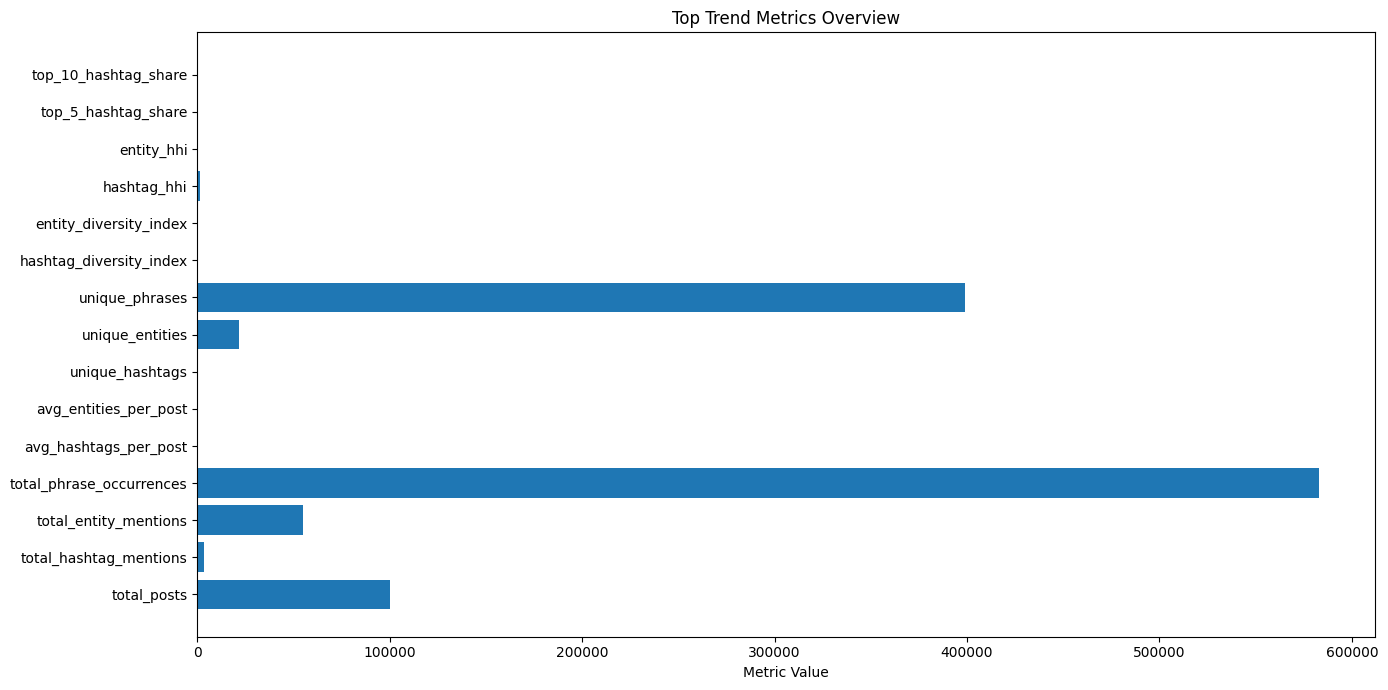

In [15]:
import matplotlib.pyplot as plt

# Convert metrics dictionary to lists for plotting
metric_names = list(all_metrics.keys())
metric_values = list(all_metrics.values())

# Remove non-numeric metrics (like categories, strings)
numeric_names = []
numeric_values = []

for name, val in zip(metric_names, metric_values):
    if isinstance(val, (int, float)):
        numeric_names.append(name)
        numeric_values.append(val)

# Plot the top 15 most important metrics
plt.figure(figsize=(14, 7))
plt.barh(numeric_names[:15], numeric_values[:15])
plt.xlabel("Metric Value")
plt.title("Top Trend Metrics Overview")
plt.tight_layout()
plt.show()


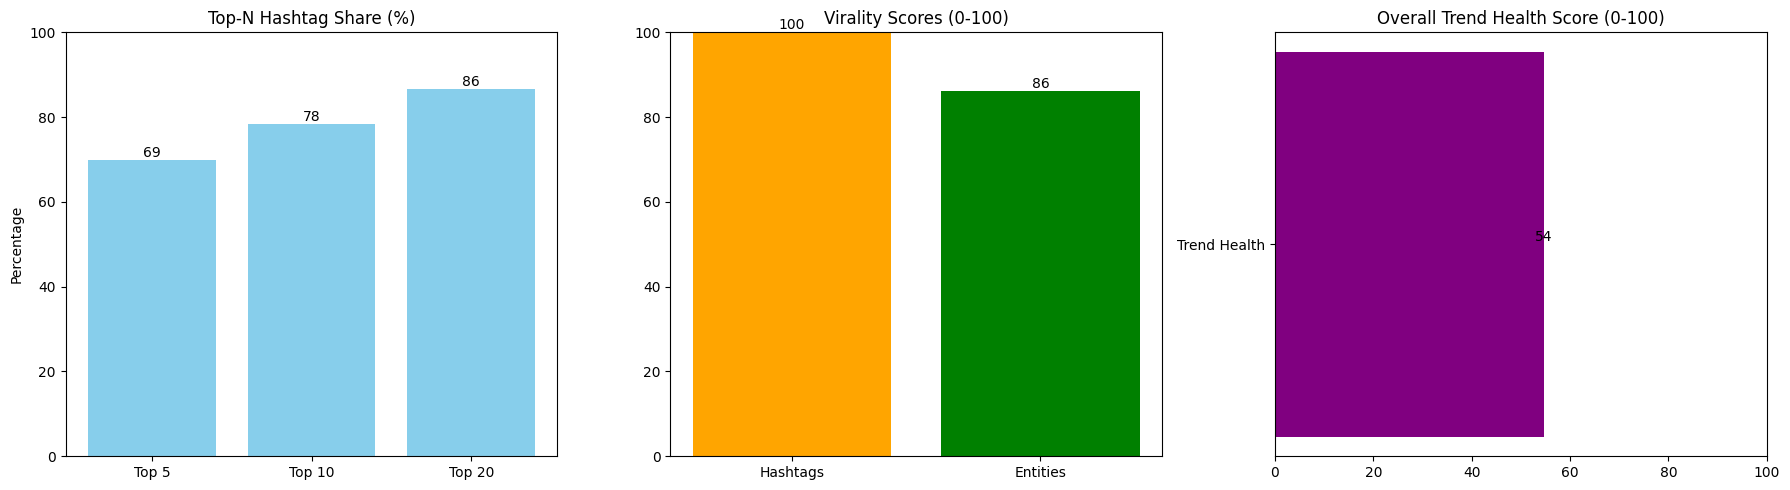

In [21]:
import matplotlib.pyplot as plt

# Data for plotting
top_n_labels = ['Top 5', 'Top 10', 'Top 20']
top_n_hashtags = [
    all_metrics['top_5_hashtag_share'],
    all_metrics['top_10_hashtag_share'],
    all_metrics['top_20_hashtag_share']
]

virality_scores = [
    all_metrics['hashtag_virality_score'],
    all_metrics['entity_virality_score']
]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1️⃣ Top-N Hashtag Share (Bar Chart)
axes[0].bar(top_n_labels, top_n_hashtags, color='skyblue')
axes[0].set_title('Top-N Hashtag Share (%)')
axes[0].set_ylabel('Percentage')
axes[0].set_ylim(0, 100)

# 2️⃣ Virality Scores (Bar Chart)
axes[1].bar(['Hashtags', 'Entities'], virality_scores, color=['orange', 'green'])
axes[1].set_title('Virality Scores (0-100)')
axes[1].set_ylim(0, 100)

# 3️⃣ Overall Trend Health Score (Gauge-like)
axes[2].barh(['Trend Health'], [trend_health_score], color='purple')
axes[2].set_xlim(0, 100)
axes[2].set_title('Overall Trend Health Score (0-100)')

# Add labels on bars
for ax in axes:
    for bar in ax.patches:
        width = bar.get_width() if ax in [axes[2]] else bar.get_height()
        x = bar.get_x() + bar.get_width()/2 if ax in [axes[0], axes[1]] else width
        y = bar.get_height() if ax in [axes[0], axes[1]] else 0
        label = f"{int(width) if ax in [axes[2]] else int(y)}"
        ax.annotate(label, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# -------------------------------
# 1️⃣ Load your data
# -------------------------------
file_path = ("../dataset/combined_cleaned_social_media.csv")  
df = pd.read_csv(file_path)
texts = df['text'].astype(str)

# -------------------------------
# 2️⃣ Train/Validation/Test Split
# -------------------------------
train_texts, test_texts = train_test_split(texts, test_size=0.2, random_state=42)
train_texts, val_texts = train_test_split(train_texts, test_size=0.25, random_state=42)  # 0.25*0.8 = 0.2

# -------------------------------
# 3️⃣ Vectorization (TF-IDF)
# -------------------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

# -------------------------------
# 4️⃣ Dimensionality Reduction (SVD)
# -------------------------------
svd = TruncatedSVD(n_components=50, random_state=42)  # reduced components for memory efficiency
X_train_svd = svd.fit_transform(X_train)
X_val_svd = svd.transform(X_val)
X_test_svd = svd.transform(X_test)

# -------------------------------
# 5️⃣ MiniBatchKMeans Clustering
# -------------------------------
n_clusters = 10  # adjust based on your data
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100, random_state=42)
kmeans.fit(X_train_svd)

# Get cluster labels
train_labels = kmeans.labels_
val_labels = kmeans.predict(X_val_svd)
test_labels = kmeans.predict(X_test_svd)

# -------------------------------
# 6️⃣ Evaluate clusters
# -------------------------------
print("Validation Silhouette Score:", silhouette_score(X_val_svd, val_labels))
print("Test Silhouette Score:", silhouette_score(X_test_svd, test_labels))

# -------------------------------
# 7️⃣ Optional: attach labels to your original data
# -------------------------------
train_df = pd.DataFrame({'text': train_texts, 'cluster': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'cluster': val_labels})
test_df = pd.DataFrame({'text': test_texts, 'cluster': test_labels})


Validation Silhouette Score: 0.043846456338640066
Test Silhouette Score: 0.04312665943935374
